In [1]:
# Set up environment first.
# we will need current numpy for pygrib
import numpy as np, os
if not [int(i) for i in np.__version__.split('.')] >= [1,20,1]: # check numpy version
  print('Upgrading numpy and stopping RUNTIME! When the notebook completes, please run again.')
  ! pip install --upgrade numpy    # suggested by Efosa, see also https://github.com/jswhit/pygrib/issues/192
  os.kill(os.getpid(), 9)          # kill the runtime, need to run again from the beginning! pip install pygrib
! pip install pygrib   
! wget --no-clobber https://raw.githubusercontent.com/openwfm/wrfxpy/master/src/ingest/grib_file.py
from grib_file import GribFile     # Martin's utility layer on top of  pygrib,from wrfxpy

File ‘grib_file.py’ already there; not retrieving.



## Kalman filter

The Kalman filter provides an estimate $u$ of the time evolution of some unknown process, called "nature" or "truth". We do not know with certainty what the nature is, but we can observe it at regular intervals (steps) with some error. In each step, model $F$ advances the model state $u$ in time, $ u \leftarrow F(u)$, and attempts to reconcile the state with an observation $d$ of the true state, so $u \approx d$. The filter modifies the model state $u$ to balance the uncertainty in the model and the data (this is called *analysis*) and the cycle continues. For that purpose, the filter evolves also an estimate of the uncertainly of the model.

More generally, instead of $u \approx d$, only a part of the state is observed, and $Hu \approx d$ where $H$ is a matrix, or observation function. Basically, $Hu$ is what the data would be if the model was completely accurate. 

In [2]:
import numpy as np
def ext_kf(u,P,F,Q=0,d=None,H=None,R=None):
  """
  One step of the extended Kalman filter. 
  If there is no data, only advance in time.
  :param u:   the state vector, shape n
  :param P:   the state covariance, shape (n,n)
  :param Q:   the process model noise covariance, shape (n,n)
  :param F:   the model function, maps vector u to vector F(u) and Jacobian J(u)
  :param d:   data vector, shape (m)
  :param H:   observation matrix, shape (m,n)
  :param R:   data error covariance, shape (n,n)
  :return ua: the analysis state vector, shape (n)
  :return Pa: the analysis covariance matrix, shape (n,n)
  """
  def d2(a):
    return np.atleast_2d(a) # convert to at least 2d array

  def d1(a):
    return np.atleast_1d(a) # convert to at least 1d array

  # forecast
  uf, J  = F(u)          # advance the model state in time and get the Jacobian
  uf = d1(uf)            # if scalar, make state a 1D array
  P = d2(P)              # if scalar, make Jacobian as 2D array
  Pf  = d2(J.T @ P) @ J + Q  # advance the state covariance Pf = J' * P * J + Q
  # analysis
  if d is None or not d.size :  # no data, no analysis
    return uf, Pf
  # K = P H' * inverse(H * P * H' + R) = (inverse(H * P * H' + R)*(H P))'
  H = d2(H)
  HP  = d2(H @ P)            # precompute a part used twice  
  K   = d2(np.linalg.solve( d2(HP @ H.T) + R, HP)).T  # Kalman gain
  # print('H',H)
  # print('K',K)
  res = d1(H @ d1(uf) - d)          # res = H*uf - d
  ua = uf - K @ res # analysis mean uf - K*res
  Pa = Pf - K @ d2(H @ P)        # analysis covariance
  return ua, d2(Pa)


##  A basic exponential decay model of fuel moisture




The evolution of fuel moisture content $m(t)$ is modeled by the differential equation on interval $\left[
t_{0},t_{1}\right]  $,
$$
\frac{dm}{dt}=\frac{E-m(t)}{T},\quad m(t_{0})=m_{0}.
$$
where the initial fuel moisture content $m_{0}=m\left(  t_{0}\right)  $ is the
input, and $m_{1}=m(t_{1})$ is the output. Tnus, $m_1=F(m_0)$. The parameters of the model are the
fuel moisture equilibrium $E$, assumed to be constant over the interval $\left[
t_{0},t_{1}\right]  $, NS the characteristic decay time $T$. 

We can build the general model later by calling this simple model with different
equilibria and time constants (drying, wetting, rain).

Since $E$ is constant in time, the solution can be found
analytically,
$$
m\left(  t\right)  =E+\left(  m_{0}-E\right)  e^{-t/T}%
$$
For convenience, we use $T_{1}=1/T$ instead of $T$, and the model becomes
$$
m_{1}=E+\left(  m_{0}-E\right)  e^{-\left(  t_{1}-t_{0}\right)  T_{1}}%
$$
In the extended Kalman filter, we will need the partial derivatives of $m_{1}$
with respect to the input and the parameters. Compute
$$
\frac{dm_{1}}{d_{m0}}=e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dE}=1-e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dT_{1}}=-\left(  m_{0}-E\right)  \left(  t_{1}-t_{0}\right)
e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
At the moment, we need only ${dm_{1}}/{dm_{0}}$ but we put in the code all partials for possible use in future.


In [3]:
import numpy as np
def model_decay(m0,E,partials=0,T1=0.1,tlen=1):
  exp_t = np.exp(-tlen*T1)                  # compute this subexpression only once
  m1 = E + (m0 - E)*exp_t                   # the solution at end
  if partials==0:
    return m1
  dm1_dm0 = exp_t
  if partials==1:
    return m1, np.array([dm1_dm0])          # return value and Jacobian
  dm1_dE = 1 - exp_t                        # partial derivative dm1 / dE
  dm1_dT1 = -(m0 - E)*tlen*exp_t            # partial derivative dm1 / dT1
  return m1, dm1_dm0, dm1_dE, dm1_dT1       # return value and all partial derivatives wrt m1 and parameters
  

## Kalman filter demonstration

We demonstrate the Kalman filter for this model on a simple artificial example. The model is solving the differential equation for one hour. The equilibrium $E$ is constant during the hour, but it changes over the day so that it is higher at night and lower during the day, with a 24-hour period.  First, we create the "truth" by choosing the equilibrium $E$ and solving the differential aquation every hour, with a small additive noise. The synthetic data is obtained as values of the "truth", with random noise to simulate observation error.

### Create synthetic data

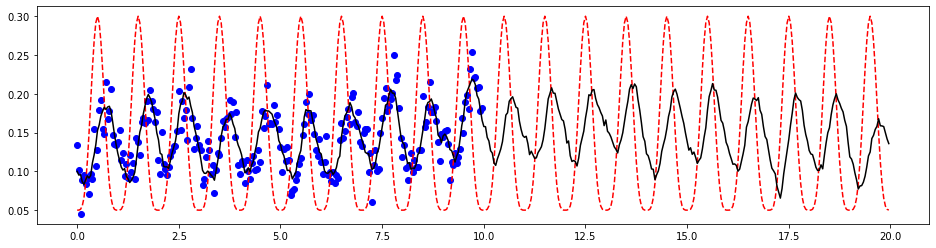

In [4]:
import numpy as np, random
days = 10       
hours = days*24
day = np.array(range(2*hours))/24.

# artificial equilibrium data
E = np.power(np.sin(np.pi*day),4) # diurnal curve
E = 0.05+0.25*E
E # scale 
# FMC free run
m_f = np.zeros(2*hours)
m_f[0] = 0.1         # initial FMC
for t in range(2*hours-1):
  m_f[t+1] = max(0.,model_decay(m_f[t],E[t])  + random.gauss(0,0.005) )
data = m_f + np.random.normal(loc=0,scale=0.02,size=2*hours)    

%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,4))
plt.plot(day[0:2*hours],E[0:2*hours],linestyle='--',c='r',label='Equilibrium')
plt.plot(day[0:2*hours],m_f[0:2*hours],linestyle='-',c='k',label='10-h fuel truth')
plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
 

### Run Kalman filter

We have used the same code for model and for the truth, and run the Kalman filter for 10 days. The graph below shows that the model state was remarkably close to the truth, even if the model is fed only noisy observations. This is because the dynamics of the model and of the truth are the same. After 10 days, we let the model continue without any new data to simulate forecasting the future, and the agreement with the truth was still very good.

In [5]:
import numpy as np
import matplotlib.pyplot as plt 

def kf_example(DeltaE):
  m = np.zeros(2*hours)
  m[0]=0.1             # background state  
  P = np.zeros(2*hours)
  P[0] = 0.03 # background state variance
  Q = np.array([0.02]) # process noise variance
  H = np.array([1.])   # all observed
  R = np.array([0.02]) # data variance

  for t in range(hours):
    # use lambda construction to pass additional arguments to the model 
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1),Q,
                    d=data[t],H=H,R=R)
  for t in range(hours,2*hours - 1):
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1))
  
  %matplotlib inline
  plt.figure() # new figure
  plt.plot(day,P,linestyle='-',c='b',label='Estimated state variance P')
    
  %matplotlib inline
  plt.figure(figsize=(16,4))
  plt.plot(day,E,linestyle='--',c='r',label='Equilibrium')
  plt.plot(day,m_f,linestyle='-',c='k',label='10-h fuel truth')
  plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
  plt.plot(day,m,linestyle='-',c='r',label='filtered')

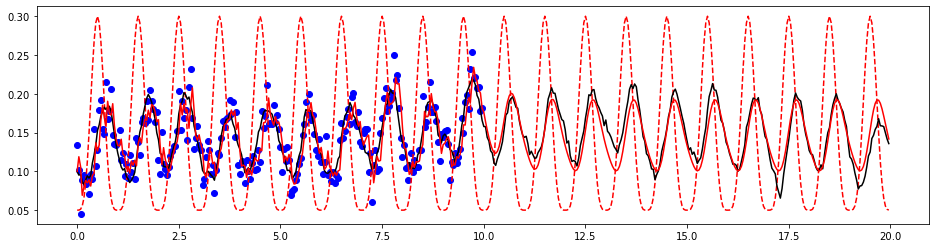

In [6]:
DeltaE = 0.0          # bias
kf_example(DeltaE)

We have recovered the fuel moisture from data with random noise - we **filtered** the noise out. 

Now what if the model is wrong - different from nature? That is always so in reality. Now suppose that the model and the truth are not the same. That is always the case in reality.  Consider a simple case when the model thinks that the equilibrium $E$ is too high.

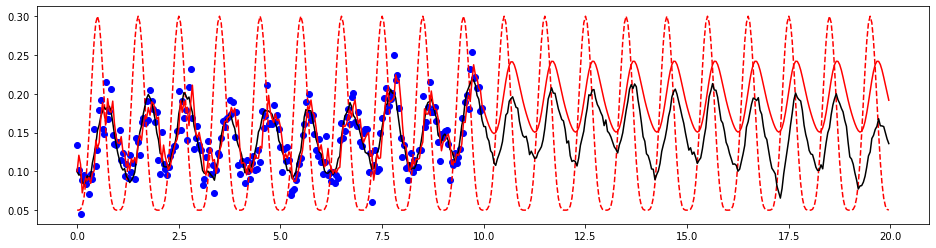

In [7]:
DeltaE = 0.05
kf_example(DeltaE)  

We have found a good estimate of the state $m$, while data is available. Also, the estimated state variance $P$ converges with time - we have *learned* the variance that balances the noise. But for forecasting fuel moisture, we need to continue the fuel moisture model into the future, and we can't have any measurements from future. We only have the equilibrium from weather forecast. And the forecast and the truth disagree.

## Real data

We retrieve the fuel moisture data from sensors on weather stations in the Mesowest network. 

In [8]:
!pip install MesoPy
from MesoPy import Meso

 Get all stations with fuel moisture data in a spatial box within one hour: 

In [9]:
# Take the first station in the boulding box that has data between time_start and time_s2.
# Then retrieve data for that station between time_start and time_end
time_start = "201806010800"  # June 1 2018 08:00 in format yyyymmddHHMM
time_s2   = "201806010900"  # June 1 2018 09:00 in format yyyymmddHHMM 
time_end   = "201906200900"  # Nov 1 2018 09:00 in format yyyymmddHHMM 
#time_start=  "201810230100"
#time_s2=  "201810230300"
#time_end=  "201810232300"
bounding_box = "-115, 38, -110, 40"  # min longtitude, latitude
meso_token="b40cb52cbdef43ef81329b84e8fd874f"       # you should get your own if you do more of this
m = Meso(meso_token)                                     # create a Meso object
meso_obss = m.timeseries(time_start, time_s2, bbox=bounding_box, showemptystations = '0', vars='fuel_moisture')   # ask the object for data

In [10]:
meso_obss

{'UNITS': {'position': 'ft', 'fuel_moisture': 'gm', 'elevation': 'ft'},
 'QC_SUMMARY': {'QC_CHECKS_APPLIED': ['sl_range_check'],
  'TOTAL_OBSERVATIONS_FLAGGED': 0.0,
  'PERCENT_OF_TOTAL_OBSERVATIONS_FLAGGED': 0.0},
 'STATION': [{'STATUS': 'ACTIVE',
   'MNET_ID': '2',
   'PERIOD_OF_RECORD': {'start': '1997-01-01T00:00:00Z',
    'end': '2021-11-06T22:27:00Z'},
   'ELEVATION': '6493',
   'NAME': 'BLACK CEDAR',
   'STID': 'BKCU1',
   'SENSOR_VARIABLES': {'date_time': {'date_time': {}},
    'fuel_moisture': {'fuel_moisture_set_1': {'position': '0.98'}}},
   'ELEV_DEM': '6499.3',
   'LONGITUDE': '-112.238864',
   'STATE': 'UT',
   'OBSERVATIONS': {'date_time': ['2018-06-01T08:27:00Z'],
    'fuel_moisture_set_1': [4.9]},
   'RESTRICTED': False,
   'QC_FLAGGED': False,
   'LATITUDE': '38.979242',
   'TIMEZONE': 'America/Denver',
   'ID': '2328'},
  {'STATUS': 'ACTIVE',
   'MNET_ID': '2',
   'PERIOD_OF_RECORD': {'start': '1998-07-30T00:00:00Z',
    'end': '2021-11-06T22:12:00Z'},
   'ELEVATION'

Print the result:

In [11]:
import json
print(json.dumps(meso_obss, indent=4))


{
    "UNITS": {
        "position": "ft",
        "fuel_moisture": "gm",
        "elevation": "ft"
    },
    "QC_SUMMARY": {
        "QC_CHECKS_APPLIED": [
            "sl_range_check"
        ],
        "TOTAL_OBSERVATIONS_FLAGGED": 0.0,
        "PERCENT_OF_TOTAL_OBSERVATIONS_FLAGGED": 0.0
    },
    "STATION": [
        {
            "STATUS": "ACTIVE",
            "MNET_ID": "2",
            "PERIOD_OF_RECORD": {
                "start": "1997-01-01T00:00:00Z",
                "end": "2021-11-06T22:27:00Z"
            },
            "ELEVATION": "6493",
            "NAME": "BLACK CEDAR",
            "STID": "BKCU1",
            "SENSOR_VARIABLES": {
                "date_time": {
                    "date_time": {}
                },
                "fuel_moisture": {
                    "fuel_moisture_set_1": {
                        "position": "0.98"
                    }
                }
            },
            "ELEV_DEM": "6499.3",
            "LONGITUDE": "-112.238864",

Pick one station and get a time series for the station.

In [12]:
station=meso_obss['STATION'][0]
#print(json.dumps(station, indent=4))
lon,lat = (float(station['LONGITUDE']),float(station['LATITUDE']))
print(station['NAME'],'station',station['STID'],'at',lon,lat)
e = 0.01
bb = '%s, %s, %s, %s' % (lon - e, lat - e, lon + e, lat + e)
print('bounding box',bb)
meso_ts = m.timeseries(time_start, time_end, bbox=bb, showemptystations = '0', vars='fuel_moisture')   # ask the object for data
obs_lon, obs_lat = (lon, lat)   # remember station coordinates for later

BLACK CEDAR station BKCU1 at -112.238864 38.979242
bounding box -112.24886400000001, 38.969242, -112.228864, 38.989242


Text(0.5, 1.0, 'BKCU1 10 h fuel moisture data')

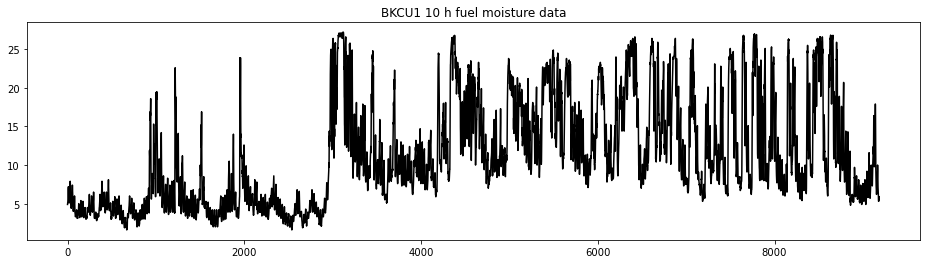

In [13]:
# process the data retrieved for this station
# print(json.dumps(meso_ts['STATION'][0], indent=4))
from datetime import datetime, timedelta, time
import pytz
station = meso_ts['STATION'][0]
time_str  = station['OBSERVATIONS']['date_time']
obs_time = [datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=pytz.UTC) for t in time_str]
start_time = obs_time[0].replace(minute=0)     # remember obs_time and start_time for later
end_time = obs_time[-1]
obs_data = np.array(station['OBSERVATIONS']["fuel_moisture_set_1"])
# display the data retrieved
#for o_time,o_data in zip (obs_time,obs_data):
#    print(o_time,o_data)
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(obs_data,linestyle='-',c='k',label='10-h fuel data')
plt.title(station['STID'] + ' 10 h fuel moisture data')


Next, we retrieve weather data for the duration of the station data, from our RTMA stash.

Create a function to transfer RTMA files in GRIB2 format from the stash. The function returns zero if the file transfer succeeded. If the file is not available, it returns a nonzero value. Note: if needed, maybe in future add more sophisticated checks, check the return code of wget and if the file size is correct.

In [14]:
import subprocess,os
def load_rtma(path,file,reload=0):
  url='http://math.ucdenver.edu/~jmandel/rtma/' + path 
  if os.path.exists(file):
    if reload:
      print(file + ' already exists, removing')
      os.remove(file)
    else:
      print(file + ' already exists, exiting')
      # add checking size here
      return 0
  try:
    ret = subprocess.check_output(['wget','--no-clobber','--output-document='+ file, url,],stderr=subprocess.STDOUT).decode() # execute command from python strings
    if os.path.exists(file):
      print('loaded ' + url + ' as ' + file)
      return 0
    else: 
      print('file transfer completed, but the file is missing? ' + url)  
      return 1
  except:
    print('file transfer failed: ' + url)
    return 2


Next, functions to get the files, open as grib, and interpolate to the station coordinates

In [15]:
def rtma_grib(t,var):
    tpath = '%4i%02i%02i/%02i' % (t.year, t.month, t.day, t.hour)
    tstr  = '%4i%02i%02i%02i_' % (t.year, t.month, t.day, t.hour)
    gribfile = tstr + var + '.grib'
    if load_rtma(tpath + '/' + var + '.grib',gribfile):
        print('cannot load file')
        return []
    else:
        try:
            gf=GribFile(gribfile)
            v = np.array(gf[1].values())
        except:
            print('cannot read grib file')
            return []
        print('loaded ',gribfile,' containing array shape ',v.shape)
        return gf[1]   # grib message


In [16]:
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root
def interp_to_lat_lon_slow(lats,lons,v,lat,lon): 
    # on mesh with coordinates lats and lons interpolate v to given lat lon
    interp=LinearNDInterpolator(list(zip(lats.flatten(),lons.flatten())),v.flatten())
    return interp(lat,lon)
def interp_to_lat_lon(lats,lons,v,lat,lon):
    # on mesh with coordinates lats and lons interpolate v to given lat lon
    points=(np.array(range(lats.shape[0]),float),np.array(range(lats.shape[1]),float))  # uniform mesh
    def res(ij):  # interpolation of lons lats on the uniform mesh, to noninteger coordinates   
       return np.hstack((interpn(points,lats,ij)-lat, interpn(points,lons,ij)-lon))
    # solve for xi,xj such that lats(xi,xj)=lat lons(xi,xj)=lon, then interpolate to (xi, xj) on uniform grid 
    result = root(res,(0,0)) # solve res(ij) = 0
    if not result.success:
        print(result.message)
        exit(1)
    return interpn(points,v,result.x) 


The interpolation function needs to  be tested.

In [17]:
def interp_to_lat_lon_test(lats,lons):
    print('testing interp_to_lat_lon')
    vx, vy = np.meshgrid(range(lats.shape[0]),range(lats.shape[1]),indexing='ij')
    i, j = (1,2)
    lat,lon = ((lats[i,j]+lats[i+1,j+1])/2,(lons[i,j]+lons[i+1,j+1])/2)
    vi = interp_to_lat_lon(lats,lons,vx,lat,lon)
    vj = interp_to_lat_lon(lats,lons,vy,lat,lon)
    print(vi,vj,'should be about',i+0.5,j+0.5)
    test_slow = 0
    if test_slow:
        print('Testing against the standard slow method scipy.interpolate.LinearNDInterpolator. Please wait...')
        vi_slow = interp_to_lat_lon_slow(lats,lons,vx,lat,lon)
        print(vi_slow)
        vj_slow = interp_to_lat_lon_slow(lats,lons,vy,lat,lon)
        print(vj_slow)
gf = rtma_grib(start_time,'temp')      #  read the first grib file and use it to test interpolation
lats, lons = gf.latlons()
interp_to_lat_lon_test(lats,lons)


2018060108_temp.grib already exists, exiting
loaded  2018060108_temp.grib  containing array shape  (1377, 2145)
testing interp_to_lat_lon
[1.50000185] [2.50004253] should be about 1.5 2.5


Now we are ready to reading the RTMA files and interpolate to the station coordinates

In [ ]:
import pandas as pd, json
def read_interp_rtma(varname,times,lat,lon):
    # read RTMA from start_time to end_time and interpolate to obs_lat obs_los
    ntimes = len(times)
    ret=np.full(ntimes,np.nan)  # initialize array of nans
    n=0
    for t in times:
       gf = rtma_grib(t,varname)   # read and create grib object, download if needed
       if gf:
         lats,lons = gf.latlons()    # coordinates
         v = gf.values()
         ret[n]=interp_to_lat_lon(lats,lons,v,lat,lon) # append to array
         print(varname,'at',t,'interpolated to',lat,lon,' value ',ret[n])
         n = n+1
       else:
         print(varname,'at',t,' could not be loaded')
    return np.array(ret)

times = pd.date_range(start=start_time,end=end_time,freq='1H')
temp =    read_interp_rtma('temp',times,obs_lat,obs_lon)      # temperature
td =      read_interp_rtma('td',times,obs_lat,obs_lon)        # dew point
precipa = read_interp_rtma('precipa',times,obs_lat,obs_lon)   # precipitation
time_str = times.strftime('%Y-%m-%d %H:%M')

j = {'temp':list(temp),'td':list(td),'precipa':list(precipa),'times_str':list(time_str),'lat':obs_lat,'lon':obs_lon}
json.dump(j,open('rtma.json','w'),indent=4)
print('Done. Strongly suggested save these arrays and obs_time obs_data to files and just start from that next time.')

2018060108_temp.grib already exists, exiting
loaded  2018060108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-01 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  286.7814329168852
2018060109_temp.grib already exists, exiting
loaded  2018060109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-01 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  285.5069057708587
2018060110_temp.grib already exists, exiting
loaded  2018060110_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-01 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.84876100750085
2018060111_temp.grib already exists, exiting
loaded  2018060111_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-01 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.3875015133747
2018060112_temp.grib already exists, exiting
loaded  2018060112_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-01 12:00:00+00:00 interpolated 

temp at 2018-06-02 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.8910676811338
2018060300_temp.grib already exists, exiting
loaded  2018060300_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-03 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.8677295216072
2018060301_temp.grib already exists, exiting
loaded  2018060301_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-03 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.9600314072609
2018060302_temp.grib already exists, exiting
loaded  2018060302_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-03 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.26494605885705
2018060303_temp.grib already exists, exiting
loaded  2018060303_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-03 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.4919005041942
2018060304_temp.grib already exists, exiting
loaded  20180603

temp at 2018-06-04 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.6444972391074
2018060415_temp.grib already exists, exiting
loaded  2018060415_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-04 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.3618082791615
2018060416_temp.grib already exists, exiting
loaded  2018060416_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-04 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.2285489232667
2018060417_temp.grib already exists, exiting
loaded  2018060417_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-04 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.1556360756361
2018060418_temp.grib already exists, exiting
loaded  2018060418_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-04 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.113664466866
2018060419_temp.grib already exists, exiting
loaded  2018060419

temp at 2018-06-06 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.7017192748076
2018060606_temp.grib already exists, exiting
loaded  2018060606_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-06 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.1221826093144
2018060607_temp.grib already exists, exiting
loaded  2018060607_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-06 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.3235936551967
2018060608_temp.grib already exists, exiting
loaded  2018060608_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-06 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.39032815605066
2018060609_temp.grib already exists, exiting
loaded  2018060609_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-06 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.2344369088248
2018060610_temp.grib already exists, exiting
loaded  20180606

temp at 2018-06-07 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.0048012439597
2018060721_temp.grib already exists, exiting
loaded  2018060721_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-07 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.9091208356956
2018060722_temp.grib already exists, exiting
loaded  2018060722_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-07 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.01854700073136
2018060723_temp.grib already exists, exiting
loaded  2018060723_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-07 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.1295883393506
2018060800_temp.grib already exists, exiting
loaded  2018060800_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-08 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.7647828618772
2018060801_temp.grib already exists, exiting
loaded  20180608

temp at 2018-06-09 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.7229331261109
2018060912_temp.grib already exists, exiting
loaded  2018060912_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-09 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.7510599026947
2018060913_temp.grib already exists, exiting
loaded  2018060913_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-09 13:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.8018776940141
2018060914_temp.grib already exists, exiting
loaded  2018060914_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-09 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.0943876897123
2018060915_temp.grib already exists, exiting
loaded  2018060915_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-09 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.4791876026919
2018060916_temp.grib already exists, exiting
loaded  201806091

temp at 2018-06-11 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.03133057997076
2018061103_temp.grib already exists, exiting
loaded  2018061103_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-11 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.3535904695716
2018061104_temp.grib already exists, exiting
loaded  2018061104_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-11 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  288.1612415325758
2018061105_temp.grib already exists, exiting
loaded  2018061105_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-11 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  286.3038923641686
2018061106_temp.grib already exists, exiting
loaded  2018061106_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-11 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  285.73891678386934
2018061107_temp.grib already exists, exiting
loaded  2018061

temp at 2018-06-12 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.5235161801181
2018061218_temp.grib already exists, exiting
loaded  2018061218_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-12 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.3732129335898
2018061219_temp.grib already exists, exiting
loaded  2018061219_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-12 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.05523115443714
2018061220_temp.grib already exists, exiting
loaded  2018061220_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-12 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.5251734285968
2018061221_temp.grib already exists, exiting
loaded  2018061221_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-12 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.4068220009859
2018061222_temp.grib already exists, exiting
loaded  20180612

temp at 2018-06-14 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.1950100793252
2018061409_temp.grib already exists, exiting
loaded  2018061409_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-14 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.53297631456485
2018061410_temp.grib already exists, exiting
loaded  2018061410_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-14 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.2193603409496
2018061411_temp.grib already exists, exiting
loaded  2018061411_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-14 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.3649716972087
2018061412_temp.grib already exists, exiting
loaded  2018061412_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-14 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.2125949288685
2018061413_temp.grib already exists, exiting
loaded  20180614

temp at 2018-06-15 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.6478064611356
2018061600_temp.grib already exists, exiting
loaded  2018061600_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-16 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.24262125393875
2018061601_temp.grib already exists, exiting
loaded  2018061601_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-16 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.96935851486734
2018061602_temp.grib already exists, exiting
loaded  2018061602_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-16 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.2956780034256
2018061603_temp.grib already exists, exiting
loaded  2018061603_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-16 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.04740403307585
2018061604_temp.grib already exists, exiting
loaded  201806

temp at 2018-06-17 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.93756786632974
2018061715_temp.grib already exists, exiting
loaded  2018061715_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-17 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.0790111110051
2018061716_temp.grib already exists, exiting
loaded  2018061716_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-17 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.6397683741174
2018061717_temp.grib already exists, exiting
loaded  2018061717_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-17 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.45868093559295
2018061718_temp.grib already exists, exiting
loaded  2018061718_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-17 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.4986585285005
2018061719_temp.grib already exists, exiting
loaded  2018061

temp at 2018-06-19 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.8677663846505
2018061906_temp.grib already exists, exiting
loaded  2018061906_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-19 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.1002479600407
2018061907_temp.grib already exists, exiting
loaded  2018061907_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-19 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  288.80210886022275
2018061908_temp.grib already exists, exiting
loaded  2018061908_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-19 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  287.7090965342577
2018061909_temp.grib already exists, exiting
loaded  2018061909_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-19 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  288.00136763872007
2018061910_temp.grib already exists, exiting
loaded  2018061

temp at 2018-06-20 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.25697239539465
2018062021_temp.grib already exists, exiting
loaded  2018062021_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-20 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.24062086757357
2018062022_temp.grib already exists, exiting
loaded  2018062022_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-20 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.06246053989224
2018062023_temp.grib already exists, exiting
loaded  2018062023_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-20 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.4661654896716
2018062100_temp.grib already exists, exiting
loaded  2018062100_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-21 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.20405992859696
2018062101_temp.grib already exists, exiting
loaded  20180

temp at 2018-06-22 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.4167655105864
2018062212_temp.grib already exists, exiting
loaded  2018062212_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-22 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.0516365255489
2018062213_temp.grib already exists, exiting
loaded  2018062213_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-22 13:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.2377032293706
2018062214_temp.grib already exists, exiting
loaded  2018062214_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-22 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.1832501288657
2018062215_temp.grib already exists, exiting
loaded  2018062215_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-22 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.1429137219029
2018062216_temp.grib already exists, exiting
loaded  201806221

temp at 2018-06-24 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.25884482727866
2018062403_temp.grib already exists, exiting
loaded  2018062403_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-24 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.66789433913164
2018062404_temp.grib already exists, exiting
loaded  2018062404_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-24 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.7936588899477
2018062405_temp.grib already exists, exiting
loaded  2018062405_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-24 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.3642873413765
2018062406_temp.grib already exists, exiting
loaded  2018062406_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-24 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.7069646425521
2018062407_temp.grib already exists, exiting
loaded  2018062

temp at 2018-06-25 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.97350849813205
2018062518_temp.grib already exists, exiting
loaded  2018062518_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-25 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.93438180319185
2018062519_temp.grib already exists, exiting
loaded  2018062519_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-25 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.00320136349336
2018062520_temp.grib already exists, exiting
loaded  2018062520_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-25 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  302.22077489632915
2018062521_temp.grib already exists, exiting
loaded  2018062521_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-25 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  302.9577031961624
2018062522_temp.grib already exists, exiting
loaded  20180

temp at 2018-06-27 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.8612854719476
2018062709_temp.grib already exists, exiting
loaded  2018062709_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-27 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.64820759903637
2018062710_temp.grib already exists, exiting
loaded  2018062710_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-27 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.0507839842399
2018062711_temp.grib already exists, exiting
loaded  2018062711_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-27 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.2389932746774
2018062712_temp.grib already exists, exiting
loaded  2018062712_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-27 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.4251514296104
2018062713_temp.grib already exists, exiting
loaded  20180627

temp at 2018-06-28 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.1668623286413
2018062900_temp.grib already exists, exiting
loaded  2018062900_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-29 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.42997404686145
2018062901_temp.grib already exists, exiting
loaded  2018062901_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-29 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  302.18906981814985
2018062902_temp.grib already exists, exiting
loaded  2018062902_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-29 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.51269379318484
2018062903_temp.grib already exists, exiting
loaded  2018062903_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-29 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.9686220232852
2018062904_temp.grib already exists, exiting
loaded  201806

temp at 2018-06-30 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.46013641223556
2018063015_temp.grib already exists, exiting
loaded  2018063015_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-30 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.12920728588546
2018063016_temp.grib already exists, exiting
loaded  2018063016_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-30 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.4150978840395
2018063017_temp.grib already exists, exiting
loaded  2018063017_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-30 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.39193872678175
2018063018_temp.grib already exists, exiting
loaded  2018063018_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-30 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.3427734441876
2018063019_temp.grib already exists, exiting
loaded  201806

temp at 2018-07-02 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.3046513949312
2018070206_temp.grib already exists, exiting
loaded  2018070206_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-02 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.96854051579044
2018070207_temp.grib already exists, exiting
loaded  2018070207_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-02 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.1938134440475
2018070208_temp.grib already exists, exiting
loaded  2018070208_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-02 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.6843893026441
2018070209_temp.grib already exists, exiting
loaded  2018070209_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-02 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.47468640926314
2018070210_temp.grib already exists, exiting
loaded  2018070

temp at 2018-07-03 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.12673974554093
2018070321_temp.grib already exists, exiting
loaded  2018070321_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-03 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.4614816566608
2018070322_temp.grib already exists, exiting
loaded  2018070322_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-03 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.8303930743356
2018070323_temp.grib already exists, exiting
loaded  2018070323_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-03 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.70306963776557
2018070400_temp.grib already exists, exiting
loaded  2018070400_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-04 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.37118772805536
2018070401_temp.grib already exists, exiting
loaded  201807

temp at 2018-07-05 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.00097710224253
2018070512_temp.grib already exists, exiting
loaded  2018070512_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-05 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.42081867320456
2018070513_temp.grib already exists, exiting
loaded  2018070513_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-05 13:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.619029992835
2018070514_temp.grib already exists, exiting
loaded  2018070514_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-05 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.06285381289996
2018070515_temp.grib already exists, exiting
loaded  2018070515_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-05 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.0819176285797
2018070516_temp.grib already exists, exiting
loaded  2018070

temp at 2018-07-07 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.62494754509504
2018070703_temp.grib already exists, exiting
loaded  2018070703_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-07 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.80105532506457
2018070704_temp.grib already exists, exiting
loaded  2018070704_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-07 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.61307088044487
2018070705_temp.grib already exists, exiting
loaded  2018070705_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-07 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.25364467998094
2018070706_temp.grib already exists, exiting
loaded  2018070706_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-07 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.700638889608
2018070707_temp.grib already exists, exiting
loaded  201807

temp at 2018-07-08 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  302.76546335519595
2018070818_temp.grib already exists, exiting
loaded  2018070818_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-08 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  304.2616747780041
2018070819_temp.grib already exists, exiting
loaded  2018070819_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-08 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  305.0945671308716
2018070820_temp.grib already exists, exiting
loaded  2018070820_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-08 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  305.2241327288448
2018070821_temp.grib already exists, exiting
loaded  2018070821_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-08 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  302.36821906004974
2018070822_temp.grib already exists, exiting
loaded  2018070

temp at 2018-07-10 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.1219616690499
2018071009_temp.grib already exists, exiting
loaded  2018071009_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-10 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.2533100458546
2018071010_temp.grib already exists, exiting
loaded  2018071010_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-10 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.1562198297422
2018071011_temp.grib already exists, exiting
loaded  2018071011_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-10 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.042245193989
2018071012_temp.grib already exists, exiting
loaded  2018071012_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-10 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.48523057827265
2018071013_temp.grib already exists, exiting
loaded  201807101

temp at 2018-07-11 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.0011169186047
2018071200_temp.grib already exists, exiting
loaded  2018071200_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-12 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.5854224168631
2018071201_temp.grib already exists, exiting
loaded  2018071201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-12 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.64341772612784
2018071202_temp.grib already exists, exiting
loaded  2018071202_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-12 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.4983532175173
2018071203_temp.grib already exists, exiting
loaded  2018071203_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-12 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.01661057602814
2018071204_temp.grib already exists, exiting
loaded  2018071

temp at 2018-07-13 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.18731185589456
2018071315_temp.grib already exists, exiting
loaded  2018071315_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-13 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.82053543374053
2018071316_temp.grib already exists, exiting
loaded  2018071316_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-13 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.13079075206286
2018071317_temp.grib already exists, exiting
loaded  2018071317_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-13 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.926128156747
2018071318_temp.grib already exists, exiting
loaded  2018071318_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-13 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.30951250744585
2018071319_temp.grib already exists, exiting
loaded  201807

temp at 2018-07-15 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.21736480785796
2018071506_temp.grib already exists, exiting
loaded  2018071506_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-15 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.5969995750742
2018071507_temp.grib already exists, exiting
loaded  2018071507_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-15 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.0518660702976
2018071508_temp.grib already exists, exiting
loaded  2018071508_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-15 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.2498685395448
2018071509_temp.grib already exists, exiting
loaded  2018071509_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-15 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.2199643558848
2018071510_temp.grib already exists, exiting
loaded  20180715

temp at 2018-07-16 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  304.9535346603315
2018071621_temp.grib already exists, exiting
loaded  2018071621_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-16 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  305.4880461507675
2018071622_temp.grib already exists, exiting
loaded  2018071622_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-16 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  305.4731791663757
2018071623_temp.grib already exists, exiting
loaded  2018071623_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-16 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  305.74005502345
2018071700_temp.grib already exists, exiting
loaded  2018071700_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-17 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  305.86177479854587
2018071701_temp.grib already exists, exiting
loaded  2018071701

temp at 2018-07-18 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.12981647465136
2018071812_temp.grib already exists, exiting
loaded  2018071812_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-18 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.7078486725561
2018071813_temp.grib already exists, exiting
loaded  2018071813_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-18 13:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.94337457013444
2018071814_temp.grib already exists, exiting
loaded  2018071814_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-18 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.63435268743046
2018071815_temp.grib already exists, exiting
loaded  2018071815_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-18 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.11103927546907
2018071816_temp.grib already exists, exiting
loaded  20180

temp at 2018-07-20 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.90011895524424
2018072003_temp.grib already exists, exiting
loaded  2018072003_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-20 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.04548061869974
2018072004_temp.grib already exists, exiting
loaded  2018072004_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-20 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.40214963881857
2018072005_temp.grib already exists, exiting
loaded  2018072005_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-20 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.90332384993394
2018072006_temp.grib already exists, exiting
loaded  2018072006_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-20 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.6386954321582
2018072007_temp.grib already exists, exiting
loaded  20180

temp at 2018-07-21 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.5203495810911
2018072118_temp.grib already exists, exiting
loaded  2018072118_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-21 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  302.6791746854758
2018072119_temp.grib already exists, exiting
loaded  2018072119_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-21 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.3345471274955
2018072120_temp.grib already exists, exiting
loaded  2018072120_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-21 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  304.2707281670138
2018072121_temp.grib already exists, exiting
loaded  2018072121_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-21 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  304.86047599090244
2018072122_temp.grib already exists, exiting
loaded  20180721

temp at 2018-07-23 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.68031064878136
2018072309_temp.grib already exists, exiting
loaded  2018072309_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-23 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.7743848107217
2018072310_temp.grib already exists, exiting
loaded  2018072310_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-23 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.9048409652085
2018072311_temp.grib already exists, exiting
loaded  2018072311_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-23 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.45173836957974
2018072312_temp.grib already exists, exiting
loaded  2018072312_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-23 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.18468285560414
2018072313_temp.grib already exists, exiting
loaded  201807

temp at 2018-07-24 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  306.36522799867964
2018072500_temp.grib already exists, exiting
loaded  2018072500_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-25 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  304.0212707460937
2018072501_temp.grib already exists, exiting
loaded  2018072501_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-25 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.7098478644679
2018072502_temp.grib already exists, exiting
loaded  2018072502_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-25 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.58714400708766
2018072503_temp.grib already exists, exiting
loaded  2018072503_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-25 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.9290957705409
2018072504_temp.grib already exists, exiting
loaded  2018072

temp at 2018-07-26 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.5837720230371
2018072615_temp.grib already exists, exiting
loaded  2018072615_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-26 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.30993085042
2018072616_temp.grib already exists, exiting
loaded  2018072616_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-26 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.6311696574191
2018072617_temp.grib already exists, exiting
loaded  2018072617_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-26 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.3797101813633
2018072618_temp.grib already exists, exiting
loaded  2018072618_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-26 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.44723972697454
2018072619_temp.grib already exists, exiting
loaded  2018072619

temp at 2018-07-28 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.5147153486072
2018072806_temp.grib already exists, exiting
loaded  2018072806_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-28 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.22086544703075
2018072807_temp.grib already exists, exiting
loaded  2018072807_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-28 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.207565723407
2018072808_temp.grib already exists, exiting
loaded  2018072808_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-28 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.5665413108743
2018072809_temp.grib already exists, exiting
loaded  2018072809_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-28 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.8703578544661
2018072810_temp.grib already exists, exiting
loaded  201807281

temp at 2018-07-29 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.9443636639193
2018072921_temp.grib already exists, exiting
loaded  2018072921_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-29 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  304.8339472080522
2018072922_temp.grib already exists, exiting
loaded  2018072922_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-29 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  305.31792507690886
2018072923_temp.grib already exists, exiting
loaded  2018072923_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-29 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  305.3984574988487
2018073000_temp.grib already exists, exiting
loaded  2018073000_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-30 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  305.13802409129846
2018073001_temp.grib already exists, exiting
loaded  2018073

temp at 2018-07-31 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.0198978472972
2018073112_temp.grib already exists, exiting
loaded  2018073112_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-31 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.60062621335766
2018073113_temp.grib already exists, exiting
loaded  2018073113_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-31 13:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.2406559676118
2018073114_temp.grib already exists, exiting
loaded  2018073114_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-31 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.9130594038341
2018073115_temp.grib already exists, exiting
loaded  2018073115_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-31 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.14873675094816
2018073116_temp.grib already exists, exiting
loaded  2018073

temp at 2018-08-02 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  302.3148198512412
2018080203_temp.grib already exists, exiting
loaded  2018080203_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-02 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.5252322492632
2018080204_temp.grib already exists, exiting
loaded  2018080204_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-02 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.83470120225843
2018080205_temp.grib already exists, exiting
loaded  2018080205_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-02 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.35450218920863
2018080206_temp.grib already exists, exiting
loaded  2018080206_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-02 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.4784383328456
2018080207_temp.grib already exists, exiting
loaded  2018080

temp at 2018-08-03 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.9356984189719
2018080318_temp.grib already exists, exiting
loaded  2018080318_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-03 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.2541827719502
2018080319_temp.grib already exists, exiting
loaded  2018080319_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-03 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.7603784781429
2018080320_temp.grib already exists, exiting
loaded  2018080320_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-03 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.7614179526587
2018080321_temp.grib already exists, exiting
loaded  2018080321_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-03 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  302.48002201012116
2018080322_temp.grib already exists, exiting
loaded  20180803

temp at 2018-08-05 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.4824877780036
2018080509_temp.grib already exists, exiting
loaded  2018080509_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-05 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.0714178946013
2018080510_temp.grib already exists, exiting
loaded  2018080510_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-05 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.2363492953106
2018080511_temp.grib already exists, exiting
loaded  2018080511_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-05 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.6579264492508
2018080512_temp.grib already exists, exiting
loaded  2018080512_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-05 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.23944739679695
2018080513_temp.grib already exists, exiting
loaded  20180805

temp at 2018-08-06 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.2906299083551
2018080700_temp.grib already exists, exiting
loaded  2018080700_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-07 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  302.90845749884863
2018080701_temp.grib already exists, exiting
loaded  2018080701_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-07 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  302.0137441397504
2018080702_temp.grib already exists, exiting
loaded  2018080702_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-07 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.99972536020994
2018080703_temp.grib already exists, exiting
loaded  2018080703_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-07 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.02694361483196
2018080704_temp.grib already exists, exiting
loaded  201808

temp at 2018-08-08 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.52540151102636
2018080815_temp.grib already exists, exiting
loaded  2018080815_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-08 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.18186404164544
2018080816_temp.grib already exists, exiting
loaded  2018080816_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-08 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.2843360705716
2018080817_temp.grib already exists, exiting
loaded  2018080817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-08 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.7860278642499
2018080818_temp.grib already exists, exiting
loaded  2018080818_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-08 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.4355639365101
2018080819_temp.grib already exists, exiting
loaded  2018080

temp at 2018-08-10 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.901401675644
2018081006_temp.grib already exists, exiting
loaded  2018081006_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-10 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.54174859757626
2018081007_temp.grib already exists, exiting
loaded  2018081007_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-10 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.39742906167896
2018081008_temp.grib already exists, exiting
loaded  2018081008_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-10 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.82011501944896
2018081009_temp.grib already exists, exiting
loaded  2018081009_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-10 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.1315177897377
2018081010_temp.grib already exists, exiting
loaded  2018081

temp at 2018-08-11 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  304.1078558316233
2018081121_temp.grib already exists, exiting
loaded  2018081121_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-11 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  302.36854152285935
2018081122_temp.grib already exists, exiting
loaded  2018081122_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-11 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  304.40062030642673
2018081123_temp.grib already exists, exiting
loaded  2018081123_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-11 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  303.94258698216413
2018081200_temp.grib already exists, exiting
loaded  2018081200_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-12 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  304.52088379331053
2018081201_temp.grib already exists, exiting
loaded  20180

temp at 2018-08-13 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.6114674991908
2018081312_temp.grib already exists, exiting
loaded  2018081312_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-13 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.00803198384045
2018081313_temp.grib already exists, exiting
loaded  2018081313_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-13 13:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.4072787811664
2018081314_temp.grib already exists, exiting
loaded  2018081314_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-13 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.1714931781568
2018081315_temp.grib already exists, exiting
loaded  2018081315_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-13 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.6946812879306
2018081316_temp.grib already exists, exiting
loaded  20180813

temp at 2018-08-15 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.3330388558253
2018081503_temp.grib already exists, exiting
loaded  2018081503_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-15 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.7977298104243
2018081504_temp.grib already exists, exiting
loaded  2018081504_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-15 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.7579021858341
2018081505_temp.grib already exists, exiting
loaded  2018081505_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-15 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.0445384412014
2018081506_temp.grib already exists, exiting
loaded  2018081506_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-15 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.6440470672196
2018081507_temp.grib already exists, exiting
loaded  201808150

temp at 2018-08-16 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.7846751732436
2018081618_temp.grib already exists, exiting
loaded  2018081618_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-16 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.9397857843524
2018081619_temp.grib already exists, exiting
loaded  2018081619_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-16 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.2715338504681
2018081620_temp.grib already exists, exiting
loaded  2018081620_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-16 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.1269363661756
2018081621_temp.grib already exists, exiting
loaded  2018081621_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-16 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.20095216340843
2018081622_temp.grib already exists, exiting
loaded  20180816

temp at 2018-08-18 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.49027113862917
2018081809_temp.grib already exists, exiting
loaded  2018081809_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-18 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.9485710719504
2018081810_temp.grib already exists, exiting
loaded  2018081810_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-18 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.8028473481628
2018081811_temp.grib already exists, exiting
loaded  2018081811_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-18 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.06659726647115
2018081812_temp.grib already exists, exiting
loaded  2018081812_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-18 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.69121310724944
2018081813_temp.grib already exists, exiting
loaded  201808

temp at 2018-08-19 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.6781712496362
2018082000_temp.grib already exists, exiting
loaded  2018082000_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-20 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.33679368658807
2018082001_temp.grib already exists, exiting
loaded  2018082001_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-20 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.5708390683403
2018082002_temp.grib already exists, exiting
loaded  2018082002_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-20 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.55836560604723
2018082003_temp.grib already exists, exiting
loaded  2018082003_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-20 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.2675098134429
2018082004_temp.grib already exists, exiting
loaded  2018082

temp at 2018-08-21 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.6085634070329
2018082115_temp.grib already exists, exiting
loaded  2018082115_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-21 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.7140763319309
2018082116_temp.grib already exists, exiting
loaded  2018082116_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-21 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.32110834064605
2018082117_temp.grib already exists, exiting
loaded  2018082117_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-21 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.88768756023353
2018082118_temp.grib already exists, exiting
loaded  2018082118_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-21 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.7681660509578
2018082119_temp.grib already exists, exiting
loaded  2018082

temp at 2018-08-23 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.2706833357604
2018082306_temp.grib already exists, exiting
loaded  2018082306_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-23 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.02162379847954
2018082307_temp.grib already exists, exiting
loaded  2018082307_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-23 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.22998262147803
2018082308_temp.grib already exists, exiting
loaded  2018082308_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-23 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.56169692372026
2018082309_temp.grib already exists, exiting
loaded  2018082309_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-23 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.1237664231152
2018082310_temp.grib already exists, exiting
loaded  201808

temp at 2018-08-24 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.62575907424866
2018082421_temp.grib already exists, exiting
loaded  2018082421_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-24 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.6373692031219
2018082422_temp.grib already exists, exiting
loaded  2018082422_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-24 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.912873271991
2018082423_temp.grib already exists, exiting
loaded  2018082423_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-24 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.42968066510724
2018082500_temp.grib already exists, exiting
loaded  2018082500_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-25 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.0731151407213
2018082501_temp.grib already exists, exiting
loaded  20180825

temp at 2018-08-26 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.28178865143224
2018082612_temp.grib already exists, exiting
loaded  2018082612_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-26 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.5420328990312
2018082613_temp.grib already exists, exiting
loaded  2018082613_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-26 13:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.3159853909123
2018082614_temp.grib already exists, exiting
loaded  2018082614_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-26 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.2518478503385
2018082615_temp.grib already exists, exiting
loaded  2018082615_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-26 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.7740201810025
2018082616_temp.grib already exists, exiting
loaded  20180826

temp at 2018-08-28 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.4128963843684
2018082803_temp.grib already exists, exiting
loaded  2018082803_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-28 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.14553315531873
2018082804_temp.grib already exists, exiting
loaded  2018082804_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-28 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.3016176249862
2018082805_temp.grib already exists, exiting
loaded  2018082805_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-28 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.19496255383234
2018082806_temp.grib already exists, exiting
loaded  2018082806_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-28 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.76410602256703
2018082807_temp.grib already exists, exiting
loaded  201808

temp at 2018-08-29 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.5587362716112
2018082918_temp.grib already exists, exiting
loaded  2018082918_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-29 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.97204225497535
2018082919_temp.grib already exists, exiting
loaded  2018082919_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-29 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.0758874240382
2018082920_temp.grib already exists, exiting
loaded  2018082920_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-29 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.04392459542225
2018082921_temp.grib already exists, exiting
loaded  2018082921_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-29 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.2683648857446
2018082922_temp.grib already exists, exiting
loaded  2018082

temp at 2018-08-31 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.24580024149566
2018083109_temp.grib already exists, exiting
loaded  2018083109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-31 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.6560539136766
2018083110_temp.grib already exists, exiting
loaded  2018083110_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-31 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.0444814794523
2018083111_temp.grib already exists, exiting
loaded  2018083111_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-31 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.383673335694
2018083112_temp.grib already exists, exiting
loaded  2018083112_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-31 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.45771450990236
2018083113_temp.grib already exists, exiting
loaded  20180831

temp at 2018-09-01 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.30147723300036
2018090200_temp.grib already exists, exiting
loaded  2018090200_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-02 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.5679469436394
2018090201_temp.grib already exists, exiting
loaded  2018090201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-02 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.64615060688055
2018090202_temp.grib already exists, exiting
loaded  2018090202_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-02 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.40273901250964
2018090203_temp.grib already exists, exiting
loaded  2018090203_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-02 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.65330128293675
2018090204_temp.grib already exists, exiting
loaded  20180

temp at 2018-09-03 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.43908616342645
2018090315_temp.grib already exists, exiting
loaded  2018090315_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-03 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.8152562440666
2018090316_temp.grib already exists, exiting
loaded  2018090316_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-03 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.2757011961165
2018090317_temp.grib already exists, exiting
loaded  2018090317_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-03 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.2413669961378
2018090318_temp.grib already exists, exiting
loaded  2018090318_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-03 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.3495237781461
2018090319_temp.grib already exists, exiting
loaded  20180903

temp at 2018-09-05 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.334435430366
2018090506_temp.grib already exists, exiting
loaded  2018090506_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-05 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.3028090441411
2018090507_temp.grib already exists, exiting
loaded  2018090507_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-05 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.45082166847754
2018090508_temp.grib already exists, exiting
loaded  2018090508_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-05 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.5430314834413
2018090509_temp.grib already exists, exiting
loaded  2018090509_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-05 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.84426745005237
2018090510_temp.grib already exists, exiting
loaded  20180905

temp at 2018-09-06 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.98608578245563
2018090621_temp.grib already exists, exiting
loaded  2018090621_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-06 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.16104624735846
2018090622_temp.grib already exists, exiting
loaded  2018090622_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-06 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.13716626950117
2018090623_temp.grib already exists, exiting
loaded  2018090623_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-06 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.5023262720504
2018090700_temp.grib already exists, exiting
loaded  2018090700_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-07 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.5340883173731
2018090701_temp.grib already exists, exiting
loaded  201809

temp at 2018-09-08 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.81750484460895
2018090812_temp.grib already exists, exiting
loaded  2018090812_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-08 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.5334226756882
2018090813_temp.grib already exists, exiting
loaded  2018090813_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-08 13:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.58488740922877
2018090814_temp.grib already exists, exiting
loaded  2018090814_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-08 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.9717746640715
2018090815_temp.grib already exists, exiting
loaded  2018090815_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-08 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.7382391608077
2018090816_temp.grib already exists, exiting
loaded  2018090

temp at 2018-09-10 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.0913443864754
2018091003_temp.grib already exists, exiting
loaded  2018091003_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-10 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.743436942409
2018091004_temp.grib already exists, exiting
loaded  2018091004_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-10 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.91719286874536
2018091005_temp.grib already exists, exiting
loaded  2018091005_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-10 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.9622011433142
2018091006_temp.grib already exists, exiting
loaded  2018091006_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-10 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.6253585076993
2018091007_temp.grib already exists, exiting
loaded  201809100

temp at 2018-09-11 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.0623902977048
2018091118_temp.grib already exists, exiting
loaded  2018091118_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-11 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.3495141762178
2018091119_temp.grib already exists, exiting
loaded  2018091119_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-11 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.45905130101187
2018091120_temp.grib already exists, exiting
loaded  2018091120_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-11 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.93612462387296
2018091121_temp.grib already exists, exiting
loaded  2018091121_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-11 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.44301179728023
2018091122_temp.grib already exists, exiting
loaded  201809

temp at 2018-09-13 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.14788202832204
2018091309_temp.grib already exists, exiting
loaded  2018091309_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-13 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.08278848576003
2018091310_temp.grib already exists, exiting
loaded  2018091310_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-13 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.49766338327214
2018091311_temp.grib already exists, exiting
loaded  2018091311_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-13 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.66135311062305
2018091312_temp.grib already exists, exiting
loaded  2018091312_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-13 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.5816939024761
2018091313_temp.grib already exists, exiting
loaded  20180

temp at 2018-09-14 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  301.0196498839159
2018091500_temp.grib already exists, exiting
loaded  2018091500_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-15 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  300.48782830448806
2018091501_temp.grib already exists, exiting
loaded  2018091501_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-15 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.8551019513417
2018091502_temp.grib already exists, exiting
loaded  2018091502_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-15 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.69442458780935
2018091503_temp.grib already exists, exiting
loaded  2018091503_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-15 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.5745601760507
2018091504_temp.grib already exists, exiting
loaded  2018091

temp at 2018-09-16 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.4651747543893
2018091615_temp.grib already exists, exiting
loaded  2018091615_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-16 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.5562220581645
2018091616_temp.grib already exists, exiting
loaded  2018091616_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-16 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.73031216748006
2018091617_temp.grib already exists, exiting
loaded  2018091617_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-16 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.0955893233171
2018091618_temp.grib already exists, exiting
loaded  2018091618_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-16 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.4726145452697
2018091619_temp.grib already exists, exiting
loaded  20180916

temp at 2018-09-18 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.9332729789516
2018091806_temp.grib already exists, exiting
loaded  2018091806_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-18 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.43523543953364
2018091807_temp.grib already exists, exiting
loaded  2018091807_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-18 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.93854527557994
2018091808_temp.grib already exists, exiting
loaded  2018091808_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-18 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.62357028090224
2018091809_temp.grib already exists, exiting
loaded  2018091809_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-18 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.9667580460202
2018091810_temp.grib already exists, exiting
loaded  201809

temp at 2018-09-19 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.48833002370446
2018091921_temp.grib already exists, exiting
loaded  2018091921_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-19 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.006268102231
2018091922_temp.grib already exists, exiting
loaded  2018091922_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-19 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  299.1943739277184
2018091923_temp.grib already exists, exiting
loaded  2018091923_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-19 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  298.8928624324018
2018092000_temp.grib already exists, exiting
loaded  2018092000_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-20 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  297.7515790117355
2018092001_temp.grib already exists, exiting
loaded  201809200

temp at 2018-09-21 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.65204348021166
2018092112_temp.grib already exists, exiting
loaded  2018092112_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-21 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.41045429222885
2018092113_temp.grib already exists, exiting
loaded  2018092113_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-21 13:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.08128272002665
2018092114_temp.grib already exists, exiting
loaded  2018092114_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-21 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  284.8610407450117
2018092115_temp.grib already exists, exiting
loaded  2018092115_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-21 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  288.48805007505354
2018092116_temp.grib already exists, exiting
loaded  20180

temp at 2018-09-23 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.14754299132034
2018092303_temp.grib already exists, exiting
loaded  2018092303_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-23 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.63888889037804
2018092304_temp.grib already exists, exiting
loaded  2018092304_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-23 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.14139871115526
2018092305_temp.grib already exists, exiting
loaded  2018092305_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-23 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.84199672086237
2018092306_temp.grib already exists, exiting
loaded  2018092306_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-23 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.5332446734564
2018092307_temp.grib already exists, exiting
loaded  20180

temp at 2018-09-24 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.8288579873032
2018092418_temp.grib already exists, exiting
loaded  2018092418_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-24 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.1639204719069
2018092419_temp.grib already exists, exiting
loaded  2018092419_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-24 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.58851390818575
2018092420_temp.grib already exists, exiting
loaded  2018092420_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-24 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  293.9534282531473
2018092421_temp.grib already exists, exiting
loaded  2018092421_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-24 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.0920059851651
2018092422_temp.grib already exists, exiting
loaded  20180924

temp at 2018-09-26 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.9856254489892
2018092609_temp.grib already exists, exiting
loaded  2018092609_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-26 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.4443287720116
2018092610_temp.grib already exists, exiting
loaded  2018092610_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-26 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.01507142428807
2018092611_temp.grib already exists, exiting
loaded  2018092611_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-26 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.028457261225
2018092612_temp.grib already exists, exiting
loaded  2018092612_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-26 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.99504020123885
2018092613_temp.grib already exists, exiting
loaded  20180926

temp at 2018-09-27 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.13095913529787
2018092800_temp.grib already exists, exiting
loaded  2018092800_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-28 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.5881608489374
2018092801_temp.grib already exists, exiting
loaded  2018092801_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-28 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.9899146544678
2018092802_temp.grib already exists, exiting
loaded  2018092802_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-28 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.85454914890926
2018092803_temp.grib already exists, exiting
loaded  2018092803_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-28 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.6799996512546
2018092804_temp.grib already exists, exiting
loaded  2018092

temp at 2018-09-29 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.58760278680165
2018092915_temp.grib already exists, exiting
loaded  2018092915_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-29 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  292.88812794987916
2018092916_temp.grib already exists, exiting
loaded  2018092916_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-29 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  294.0995970048597
2018092917_temp.grib already exists, exiting
loaded  2018092917_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-29 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  295.4344159723716
2018092918_temp.grib already exists, exiting
loaded  2018092918_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-29 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  296.52279823701264
2018092919_temp.grib already exists, exiting
loaded  201809

temp at 2018-10-01 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.3009636170156
2018100106_temp.grib already exists, exiting
loaded  2018100106_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-01 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.69421066506845
2018100107_temp.grib already exists, exiting
loaded  2018100107_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-01 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.5769637671579
2018100108_temp.grib already exists, exiting
loaded  2018100108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-01 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.08719507787913
2018100109_temp.grib already exists, exiting
loaded  2018100109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-01 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.6244988542592
2018100110_temp.grib already exists, exiting
loaded  2018100

temp at 2018-10-02 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.3941425457663
2018100221_temp.grib already exists, exiting
loaded  2018100221_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-02 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.2384579956286
2018100222_temp.grib already exists, exiting
loaded  2018100222_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-02 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.7776197761316
2018100223_temp.grib already exists, exiting
loaded  2018100223_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-02 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.12008279673705
2018100300_temp.grib already exists, exiting
loaded  2018100300_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-03 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  291.08588182152323
2018100301_temp.grib already exists, exiting
loaded  2018100

temp at 2018-10-04 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.6236313700495
2018100412_temp.grib already exists, exiting
loaded  2018100412_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-04 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.77312819743025
2018100413_temp.grib already exists, exiting
loaded  2018100413_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-04 13:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.5159840753244
2018100414_temp.grib already exists, exiting
loaded  2018100414_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-04 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.7725513371187
2018100415_temp.grib already exists, exiting
loaded  2018100415_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-04 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.69511161170175
2018100416_temp.grib already exists, exiting
loaded  2018100

temp at 2018-10-06 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.2221075587372
2018100603_temp.grib already exists, exiting
loaded  2018100603_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-06 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.614125460151
2018100604_temp.grib already exists, exiting
loaded  2018100604_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-06 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.0598012045378
2018100605_temp.grib already exists, exiting
loaded  2018100605_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-06 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.1731897299454
2018100606_temp.grib already exists, exiting
loaded  2018100606_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-06 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.7855938864703
2018100607_temp.grib already exists, exiting
loaded  2018100607

temp at 2018-10-07 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.75667059930163
2018100718_temp.grib already exists, exiting
loaded  2018100718_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-07 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.8139489658711
2018100719_temp.grib already exists, exiting
loaded  2018100719_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-07 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.5373973448174
2018100720_temp.grib already exists, exiting
loaded  2018100720_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-07 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.1909359196034
2018100721_temp.grib already exists, exiting
loaded  2018100721_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-07 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.844461235485
2018100722_temp.grib already exists, exiting
loaded  201810072

temp at 2018-10-09 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.8377560321775
2018100909_temp.grib already exists, exiting
loaded  2018100909_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-09 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.3732815544835
2018100910_temp.grib already exists, exiting
loaded  2018100910_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-09 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.4233410045601
2018100911_temp.grib already exists, exiting
loaded  2018100911_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-09 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.9353801995075
2018100912_temp.grib already exists, exiting
loaded  2018100912_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-09 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.7670600708207
2018100913_temp.grib already exists, exiting
loaded  201810091

temp at 2018-10-10 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.6142192114953
2018101100_temp.grib already exists, exiting
loaded  2018101100_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-11 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.01428603692335
2018101101_temp.grib already exists, exiting
loaded  2018101101_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-11 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.1624894365695
2018101102_temp.grib already exists, exiting
loaded  2018101102_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-11 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.4845809045411
2018101103_temp.grib already exists, exiting
loaded  2018101103_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-11 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.58128489578445
2018101104_temp.grib already exists, exiting
loaded  2018101

temp at 2018-10-12 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.5655317735197
2018101215_temp.grib already exists, exiting
loaded  2018101215_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-12 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.4117281386158
2018101216_temp.grib already exists, exiting
loaded  2018101216_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-12 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.55920526150413
2018101217_temp.grib already exists, exiting
loaded  2018101217_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-12 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.8173457234581
2018101218_temp.grib already exists, exiting
loaded  2018101218_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-12 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.5996657322448
2018101219_temp.grib already exists, exiting
loaded  20181012

temp at 2018-10-14 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.1765901166932
2018101406_temp.grib already exists, exiting
loaded  2018101406_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-14 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.6716801191428
2018101407_temp.grib already exists, exiting
loaded  2018101407_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-14 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.32936134283085
2018101408_temp.grib already exists, exiting
loaded  2018101408_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-14 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.8692926657239
2018101409_temp.grib already exists, exiting
loaded  2018101409_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-14 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.7602956042414
2018101410_temp.grib already exists, exiting
loaded  20181014

temp at 2018-10-15 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.44039049938647
2018101521_temp.grib already exists, exiting
loaded  2018101521_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-15 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.38505821231985
2018101522_temp.grib already exists, exiting
loaded  2018101522_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-15 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.98312971353585
2018101523_temp.grib already exists, exiting
loaded  2018101523_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-15 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.8196570485438
2018101600_temp.grib already exists, exiting
loaded  2018101600_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-16 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.37269205540207
2018101601_temp.grib already exists, exiting
loaded  20181

temp at 2018-10-17 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.7315752825983
2018101712_temp.grib already exists, exiting
loaded  2018101712_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-17 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.2088885466361
2018101713_temp.grib already exists, exiting
loaded  2018101713_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-17 13:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.91450268263293
2018101714_temp.grib already exists, exiting
loaded  2018101714_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-17 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.3069923054515
2018101715_temp.grib already exists, exiting
loaded  2018101715_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-17 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.06445086075735
2018101716_temp.grib already exists, exiting
loaded  2018101

temp at 2018-10-19 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.96972855102115
2018101903_temp.grib already exists, exiting
loaded  2018101903_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-19 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.8512800873947
2018101904_temp.grib already exists, exiting
loaded  2018101904_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-19 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.4430598733395
2018101905_temp.grib already exists, exiting
loaded  2018101905_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-19 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.5939510683458
2018101906_temp.grib already exists, exiting
loaded  2018101906_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-19 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.0118210433368
2018101907_temp.grib already exists, exiting
loaded  20181019

temp at 2018-10-20 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  286.0024324566272
2018102018_temp.grib already exists, exiting
loaded  2018102018_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-20 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  286.98024538044626
2018102019_temp.grib already exists, exiting
loaded  2018102019_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-20 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  288.435577390746
2018102020_temp.grib already exists, exiting
loaded  2018102020_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-20 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.6256363844892
2018102021_temp.grib already exists, exiting
loaded  2018102021_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-20 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.7150930923451
2018102022_temp.grib already exists, exiting
loaded  201810202

temp at 2018-10-22 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.4700576060105
2018102209_temp.grib already exists, exiting
loaded  2018102209_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-22 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.89123825087205
2018102210_temp.grib already exists, exiting
loaded  2018102210_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-22 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.21234020637223
2018102211_temp.grib already exists, exiting
loaded  2018102211_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-22 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.39732422978125
2018102212_temp.grib already exists, exiting
loaded  2018102212_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-22 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.9022207884865
2018102213_temp.grib already exists, exiting
loaded  201810

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181024/14/temp.grib
cannot load file
temp at 2018-10-24 14:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181024/15/temp.grib
cannot load file
temp at 2018-10-24 15:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181024/16/temp.grib
cannot load file
temp at 2018-10-24 16:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181024/17/temp.grib
cannot load file
temp at 2018-10-24 17:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181024/18/temp.grib
cannot load file
temp at 2018-10-24 18:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181024/19/temp.grib
cannot load file
temp at 2018-10-24 19:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181024/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181026/20/temp.grib
cannot load file
temp at 2018-10-26 20:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181026/21/temp.grib
cannot load file
temp at 2018-10-26 21:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181026/22/temp.grib
cannot load file
temp at 2018-10-26 22:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181026/23/temp.grib
cannot load file
temp at 2018-10-26 23:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181027/00/temp.grib
cannot load file
temp at 2018-10-27 00:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181027/01/temp.grib
cannot load file
temp at 2018-10-27 01:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181027/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181029/03/temp.grib
cannot load file
temp at 2018-10-29 03:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181029/04/temp.grib
cannot load file
temp at 2018-10-29 04:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181029/05/temp.grib
cannot load file
temp at 2018-10-29 05:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181029/06/temp.grib
cannot load file
temp at 2018-10-29 06:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181029/07/temp.grib
cannot load file
temp at 2018-10-29 07:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181029/08/temp.grib
cannot load file
temp at 2018-10-29 08:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181029/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181031/09/temp.grib
cannot load file
temp at 2018-10-31 09:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181031/10/temp.grib
cannot load file
temp at 2018-10-31 10:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181031/11/temp.grib
cannot load file
temp at 2018-10-31 11:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181031/12/temp.grib
cannot load file
temp at 2018-10-31 12:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181031/13/temp.grib
cannot load file
temp at 2018-10-31 13:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181031/14/temp.grib
cannot load file
temp at 2018-10-31 14:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181031/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181102/14/temp.grib
cannot load file
temp at 2018-11-02 14:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181102/15/temp.grib
cannot load file
temp at 2018-11-02 15:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181102/16/temp.grib
cannot load file
temp at 2018-11-02 16:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181102/17/temp.grib
cannot load file
temp at 2018-11-02 17:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181102/18/temp.grib
cannot load file
temp at 2018-11-02 18:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181102/19/temp.grib
cannot load file
temp at 2018-11-02 19:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181102/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181104/20/temp.grib
cannot load file
temp at 2018-11-04 20:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181104/21/temp.grib
cannot load file
temp at 2018-11-04 21:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181104/22/temp.grib
cannot load file
temp at 2018-11-04 22:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181104/23/temp.grib
cannot load file
temp at 2018-11-04 23:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181105/00/temp.grib
cannot load file
temp at 2018-11-05 00:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181105/01/temp.grib
cannot load file
temp at 2018-11-05 01:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20181105/

temp at 2018-11-06 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.18786609466133
loaded http://math.ucdenver.edu/~jmandel/rtma/20181106/15/temp.grib as 2018110615_temp.grib
loaded  2018110615_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-06 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.10421235943704
loaded http://math.ucdenver.edu/~jmandel/rtma/20181106/16/temp.grib as 2018110616_temp.grib
loaded  2018110616_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-06 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.7508886528937
loaded http://math.ucdenver.edu/~jmandel/rtma/20181106/17/temp.grib as 2018110617_temp.grib
loaded  2018110617_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-06 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.861763205819
loaded http://math.ucdenver.edu/~jmandel/rtma/20181106/18/temp.grib as 2018110618_temp.grib
loaded  2018110618_temp.grib  containi

temp at 2018-11-07 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.46379666653786
loaded http://math.ucdenver.edu/~jmandel/rtma/20181107/23/temp.grib as 2018110723_temp.grib
loaded  2018110723_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-07 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.3746889827158
loaded http://math.ucdenver.edu/~jmandel/rtma/20181108/00/temp.grib as 2018110800_temp.grib
loaded  2018110800_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-08 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.12593544647876
loaded http://math.ucdenver.edu/~jmandel/rtma/20181108/01/temp.grib as 2018110801_temp.grib
loaded  2018110801_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-08 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.060590539748
loaded http://math.ucdenver.edu/~jmandel/rtma/20181108/02/temp.grib as 2018110802_temp.grib
loaded  2018110802_temp.grib  containi

temp at 2018-11-09 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.45438922639477
loaded http://math.ucdenver.edu/~jmandel/rtma/20181109/07/temp.grib as 2018110907_temp.grib
loaded  2018110907_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-09 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.2184567618506
loaded http://math.ucdenver.edu/~jmandel/rtma/20181109/08/temp.grib as 2018110908_temp.grib
loaded  2018110908_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-09 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.0765633861085
loaded http://math.ucdenver.edu/~jmandel/rtma/20181109/09/temp.grib as 2018110909_temp.grib
loaded  2018110909_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-09 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  269.46648684448155
loaded http://math.ucdenver.edu/~jmandel/rtma/20181109/10/temp.grib as 2018110910_temp.grib
loaded  2018110910_temp.grib  contain

temp at 2018-11-10 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.18232547197664
loaded http://math.ucdenver.edu/~jmandel/rtma/20181110/15/temp.grib as 2018111015_temp.grib
loaded  2018111015_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-10 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.4755669175144
loaded http://math.ucdenver.edu/~jmandel/rtma/20181110/16/temp.grib as 2018111016_temp.grib
loaded  2018111016_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-10 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.3918851454082
loaded http://math.ucdenver.edu/~jmandel/rtma/20181110/17/temp.grib as 2018111017_temp.grib
loaded  2018111017_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-10 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.666882701521
loaded http://math.ucdenver.edu/~jmandel/rtma/20181110/18/temp.grib as 2018111018_temp.grib
loaded  2018111018_temp.grib  containin

temp at 2018-11-11 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.2730262558242
loaded http://math.ucdenver.edu/~jmandel/rtma/20181111/23/temp.grib as 2018111123_temp.grib
loaded  2018111123_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-11 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.4124091565311
loaded http://math.ucdenver.edu/~jmandel/rtma/20181112/00/temp.grib as 2018111200_temp.grib
loaded  2018111200_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-12 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.62797452715563
loaded http://math.ucdenver.edu/~jmandel/rtma/20181112/01/temp.grib as 2018111201_temp.grib
loaded  2018111201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-12 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.33208199199083
loaded http://math.ucdenver.edu/~jmandel/rtma/20181112/02/temp.grib as 2018111202_temp.grib
loaded  2018111202_temp.grib  contain

temp at 2018-11-13 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  269.2120002997436
loaded http://math.ucdenver.edu/~jmandel/rtma/20181113/07/temp.grib as 2018111307_temp.grib
loaded  2018111307_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-13 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  269.01942580461474
loaded http://math.ucdenver.edu/~jmandel/rtma/20181113/08/temp.grib as 2018111308_temp.grib
loaded  2018111308_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-13 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  268.9592776978077
loaded http://math.ucdenver.edu/~jmandel/rtma/20181113/09/temp.grib as 2018111309_temp.grib
loaded  2018111309_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-13 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  268.35117726670467
loaded http://math.ucdenver.edu/~jmandel/rtma/20181113/10/temp.grib as 2018111310_temp.grib
loaded  2018111310_temp.grib  contain

temp at 2018-11-14 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.0565161424025
loaded http://math.ucdenver.edu/~jmandel/rtma/20181114/15/temp.grib as 2018111415_temp.grib
loaded  2018111415_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-14 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.173804853832
loaded http://math.ucdenver.edu/~jmandel/rtma/20181114/16/temp.grib as 2018111416_temp.grib
loaded  2018111416_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-14 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.24560960308565
loaded http://math.ucdenver.edu/~jmandel/rtma/20181114/17/temp.grib as 2018111417_temp.grib
loaded  2018111417_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-14 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.9645451220537
loaded http://math.ucdenver.edu/~jmandel/rtma/20181114/18/temp.grib as 2018111418_temp.grib
loaded  2018111418_temp.grib  containin

temp at 2018-11-15 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.1040496588627
loaded http://math.ucdenver.edu/~jmandel/rtma/20181115/23/temp.grib as 2018111523_temp.grib
loaded  2018111523_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-15 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.94555446629533
loaded http://math.ucdenver.edu/~jmandel/rtma/20181116/00/temp.grib as 2018111600_temp.grib
loaded  2018111600_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-16 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.9442317180108
loaded http://math.ucdenver.edu/~jmandel/rtma/20181116/01/temp.grib as 2018111601_temp.grib
loaded  2018111601_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-16 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.35381253619255
loaded http://math.ucdenver.edu/~jmandel/rtma/20181116/02/temp.grib as 2018111602_temp.grib
loaded  2018111602_temp.grib  contain

temp at 2018-11-17 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.4936878480244
loaded http://math.ucdenver.edu/~jmandel/rtma/20181117/07/temp.grib as 2018111707_temp.grib
loaded  2018111707_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-17 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.8102459313886
loaded http://math.ucdenver.edu/~jmandel/rtma/20181117/08/temp.grib as 2018111708_temp.grib
loaded  2018111708_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-17 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.4865922601567
loaded http://math.ucdenver.edu/~jmandel/rtma/20181117/09/temp.grib as 2018111709_temp.grib
loaded  2018111709_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-17 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.8353802933675
loaded http://math.ucdenver.edu/~jmandel/rtma/20181117/10/temp.grib as 2018111710_temp.grib
loaded  2018111710_temp.grib  containin

temp at 2018-11-18 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  269.7397974310726
loaded http://math.ucdenver.edu/~jmandel/rtma/20181118/15/temp.grib as 2018111815_temp.grib
loaded  2018111815_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-18 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.0376967620418
loaded http://math.ucdenver.edu/~jmandel/rtma/20181118/16/temp.grib as 2018111816_temp.grib
loaded  2018111816_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-18 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.8384750343078
loaded http://math.ucdenver.edu/~jmandel/rtma/20181118/17/temp.grib as 2018111817_temp.grib
loaded  2018111817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-18 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.15156696526833
loaded http://math.ucdenver.edu/~jmandel/rtma/20181118/18/temp.grib as 2018111818_temp.grib
loaded  2018111818_temp.grib  containi

temp at 2018-11-19 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.5053168711522
loaded http://math.ucdenver.edu/~jmandel/rtma/20181119/23/temp.grib as 2018111923_temp.grib
loaded  2018111923_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-19 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.8982457778354
loaded http://math.ucdenver.edu/~jmandel/rtma/20181120/00/temp.grib as 2018112000_temp.grib
loaded  2018112000_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-20 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.675650810947
loaded http://math.ucdenver.edu/~jmandel/rtma/20181120/01/temp.grib as 2018112001_temp.grib
loaded  2018112001_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-20 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.63801921539283
loaded http://math.ucdenver.edu/~jmandel/rtma/20181120/02/temp.grib as 2018112002_temp.grib
loaded  2018112002_temp.grib  containin

temp at 2018-11-21 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.0609594384091
loaded http://math.ucdenver.edu/~jmandel/rtma/20181121/07/temp.grib as 2018112107_temp.grib
loaded  2018112107_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-21 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.3380924395134
loaded http://math.ucdenver.edu/~jmandel/rtma/20181121/08/temp.grib as 2018112108_temp.grib
loaded  2018112108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-21 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.0544380253498
loaded http://math.ucdenver.edu/~jmandel/rtma/20181121/09/temp.grib as 2018112109_temp.grib
loaded  2018112109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-21 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.3239031815017
loaded http://math.ucdenver.edu/~jmandel/rtma/20181121/10/temp.grib as 2018112110_temp.grib
loaded  2018112110_temp.grib  containin

temp at 2018-11-22 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.3909802696757
loaded http://math.ucdenver.edu/~jmandel/rtma/20181122/15/temp.grib as 2018112215_temp.grib
loaded  2018112215_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-22 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.5416796598419
loaded http://math.ucdenver.edu/~jmandel/rtma/20181122/16/temp.grib as 2018112216_temp.grib
loaded  2018112216_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-22 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.39181416790046
loaded http://math.ucdenver.edu/~jmandel/rtma/20181122/17/temp.grib as 2018112217_temp.grib
loaded  2018112217_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-22 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.4374648573385
loaded http://math.ucdenver.edu/~jmandel/rtma/20181122/18/temp.grib as 2018112218_temp.grib
loaded  2018112218_temp.grib  containi

temp at 2018-11-23 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.7586450301015
loaded http://math.ucdenver.edu/~jmandel/rtma/20181123/23/temp.grib as 2018112323_temp.grib
loaded  2018112323_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-23 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.3498429592519
loaded http://math.ucdenver.edu/~jmandel/rtma/20181124/00/temp.grib as 2018112400_temp.grib
loaded  2018112400_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-24 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.0253609568821
loaded http://math.ucdenver.edu/~jmandel/rtma/20181124/01/temp.grib as 2018112401_temp.grib
loaded  2018112401_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-24 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.20025774412846
loaded http://math.ucdenver.edu/~jmandel/rtma/20181124/02/temp.grib as 2018112402_temp.grib
loaded  2018112402_temp.grib  containi

temp at 2018-11-25 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  268.29721558322126
loaded http://math.ucdenver.edu/~jmandel/rtma/20181125/07/temp.grib as 2018112507_temp.grib
loaded  2018112507_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-25 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  267.74426910305766
loaded http://math.ucdenver.edu/~jmandel/rtma/20181125/08/temp.grib as 2018112508_temp.grib
loaded  2018112508_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-25 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  267.8363399091243
loaded http://math.ucdenver.edu/~jmandel/rtma/20181125/09/temp.grib as 2018112509_temp.grib
loaded  2018112509_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-25 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  266.9166891971261
loaded http://math.ucdenver.edu/~jmandel/rtma/20181125/10/temp.grib as 2018112510_temp.grib
loaded  2018112510_temp.grib  contain

temp at 2018-11-26 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  267.1146604058451
loaded http://math.ucdenver.edu/~jmandel/rtma/20181126/15/temp.grib as 2018112615_temp.grib
loaded  2018112615_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-26 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  266.90070402585366
loaded http://math.ucdenver.edu/~jmandel/rtma/20181126/16/temp.grib as 2018112616_temp.grib
loaded  2018112616_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-26 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  269.9146632384539
loaded http://math.ucdenver.edu/~jmandel/rtma/20181126/17/temp.grib as 2018112617_temp.grib
loaded  2018112617_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-26 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.85644076201936
loaded http://math.ucdenver.edu/~jmandel/rtma/20181126/18/temp.grib as 2018112618_temp.grib
loaded  2018112618_temp.grib  contain

temp at 2018-11-27 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.05784864231407
loaded http://math.ucdenver.edu/~jmandel/rtma/20181127/23/temp.grib as 2018112723_temp.grib
loaded  2018112723_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-27 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.1590517449206
loaded http://math.ucdenver.edu/~jmandel/rtma/20181128/00/temp.grib as 2018112800_temp.grib
loaded  2018112800_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-28 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.4813045533813
loaded http://math.ucdenver.edu/~jmandel/rtma/20181128/01/temp.grib as 2018112801_temp.grib
loaded  2018112801_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-28 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.66541294573307
loaded http://math.ucdenver.edu/~jmandel/rtma/20181128/02/temp.grib as 2018112802_temp.grib
loaded  2018112802_temp.grib  contain

temp at 2018-11-29 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.74096346731693
loaded http://math.ucdenver.edu/~jmandel/rtma/20181129/07/temp.grib as 2018112907_temp.grib
loaded  2018112907_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-29 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.1090557827296
loaded http://math.ucdenver.edu/~jmandel/rtma/20181129/08/temp.grib as 2018112908_temp.grib
loaded  2018112908_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-29 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.767685100304
loaded http://math.ucdenver.edu/~jmandel/rtma/20181129/09/temp.grib as 2018112909_temp.grib
loaded  2018112909_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-29 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.7201536475496
loaded http://math.ucdenver.edu/~jmandel/rtma/20181129/10/temp.grib as 2018112910_temp.grib
loaded  2018112910_temp.grib  containin

temp at 2018-11-30 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.52802572760834
loaded http://math.ucdenver.edu/~jmandel/rtma/20181130/15/temp.grib as 2018113015_temp.grib
loaded  2018113015_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-30 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.4358816091218
loaded http://math.ucdenver.edu/~jmandel/rtma/20181130/16/temp.grib as 2018113016_temp.grib
loaded  2018113016_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-30 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.5553693165042
loaded http://math.ucdenver.edu/~jmandel/rtma/20181130/17/temp.grib as 2018113017_temp.grib
loaded  2018113017_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-30 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.67404362561115
loaded http://math.ucdenver.edu/~jmandel/rtma/20181130/18/temp.grib as 2018113018_temp.grib
loaded  2018113018_temp.grib  contain

temp at 2018-12-01 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.01792525220435
loaded http://math.ucdenver.edu/~jmandel/rtma/20181201/23/temp.grib as 2018120123_temp.grib
loaded  2018120123_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-01 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.6947522854744
loaded http://math.ucdenver.edu/~jmandel/rtma/20181202/00/temp.grib as 2018120200_temp.grib
loaded  2018120200_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-02 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.2071237967044
loaded http://math.ucdenver.edu/~jmandel/rtma/20181202/01/temp.grib as 2018120201_temp.grib
loaded  2018120201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-02 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.13107003272796
loaded http://math.ucdenver.edu/~jmandel/rtma/20181202/02/temp.grib as 2018120202_temp.grib
loaded  2018120202_temp.grib  contain

temp at 2018-12-03 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  265.17892509970426
loaded http://math.ucdenver.edu/~jmandel/rtma/20181203/07/temp.grib as 2018120307_temp.grib
loaded  2018120307_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-03 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  264.57163116362517
loaded http://math.ucdenver.edu/~jmandel/rtma/20181203/08/temp.grib as 2018120308_temp.grib
loaded  2018120308_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-03 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  265.6213346374414
loaded http://math.ucdenver.edu/~jmandel/rtma/20181203/09/temp.grib as 2018120309_temp.grib
loaded  2018120309_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-03 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  264.2397018660706
loaded http://math.ucdenver.edu/~jmandel/rtma/20181203/10/temp.grib as 2018120310_temp.grib
loaded  2018120310_temp.grib  contain

temp at 2018-12-04 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  263.4539972216644
loaded http://math.ucdenver.edu/~jmandel/rtma/20181204/15/temp.grib as 2018120415_temp.grib
loaded  2018120415_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-04 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  263.82758844733996
loaded http://math.ucdenver.edu/~jmandel/rtma/20181204/16/temp.grib as 2018120416_temp.grib
loaded  2018120416_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-04 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  265.5723561943617
loaded http://math.ucdenver.edu/~jmandel/rtma/20181204/17/temp.grib as 2018120417_temp.grib
loaded  2018120417_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-04 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  267.5738259188245
loaded http://math.ucdenver.edu/~jmandel/rtma/20181204/18/temp.grib as 2018120418_temp.grib
loaded  2018120418_temp.grib  containi

temp at 2018-12-05 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.9966555271127
loaded http://math.ucdenver.edu/~jmandel/rtma/20181205/23/temp.grib as 2018120523_temp.grib
loaded  2018120523_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-05 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.12177039604353
loaded http://math.ucdenver.edu/~jmandel/rtma/20181206/00/temp.grib as 2018120600_temp.grib
loaded  2018120600_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-06 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.0292554724988
loaded http://math.ucdenver.edu/~jmandel/rtma/20181206/01/temp.grib as 2018120601_temp.grib
loaded  2018120601_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-06 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.0811981612134
loaded http://math.ucdenver.edu/~jmandel/rtma/20181206/02/temp.grib as 2018120602_temp.grib
loaded  2018120602_temp.grib  containi

temp at 2018-12-07 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.0467797290814
loaded http://math.ucdenver.edu/~jmandel/rtma/20181207/07/temp.grib as 2018120707_temp.grib
loaded  2018120707_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-07 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.0958165296302
loaded http://math.ucdenver.edu/~jmandel/rtma/20181207/08/temp.grib as 2018120708_temp.grib
loaded  2018120708_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-07 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.4379768769042
loaded http://math.ucdenver.edu/~jmandel/rtma/20181207/09/temp.grib as 2018120709_temp.grib
loaded  2018120709_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-07 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.29473131768253
loaded http://math.ucdenver.edu/~jmandel/rtma/20181207/10/temp.grib as 2018120710_temp.grib
loaded  2018120710_temp.grib  containi

temp at 2018-12-08 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.3880676895228
loaded http://math.ucdenver.edu/~jmandel/rtma/20181208/15/temp.grib as 2018120815_temp.grib
loaded  2018120815_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-08 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.80056813653835
loaded http://math.ucdenver.edu/~jmandel/rtma/20181208/16/temp.grib as 2018120816_temp.grib
loaded  2018120816_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-08 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.634125638414
loaded http://math.ucdenver.edu/~jmandel/rtma/20181208/17/temp.grib as 2018120817_temp.grib
loaded  2018120817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-08 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.41701555101355
loaded http://math.ucdenver.edu/~jmandel/rtma/20181208/18/temp.grib as 2018120818_temp.grib
loaded  2018120818_temp.grib  containi

temp at 2018-12-09 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.5612470412308
loaded http://math.ucdenver.edu/~jmandel/rtma/20181209/23/temp.grib as 2018120923_temp.grib
loaded  2018120923_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-09 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.95751365370046
loaded http://math.ucdenver.edu/~jmandel/rtma/20181210/00/temp.grib as 2018121000_temp.grib
loaded  2018121000_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-10 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.08356436542954
loaded http://math.ucdenver.edu/~jmandel/rtma/20181210/01/temp.grib as 2018121001_temp.grib
loaded  2018121001_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-10 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.41512311428374
loaded http://math.ucdenver.edu/~jmandel/rtma/20181210/02/temp.grib as 2018121002_temp.grib
loaded  2018121002_temp.grib  contai

temp at 2018-12-11 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.65735394618054
loaded http://math.ucdenver.edu/~jmandel/rtma/20181211/07/temp.grib as 2018121107_temp.grib
loaded  2018121107_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-11 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.5798042836716
loaded http://math.ucdenver.edu/~jmandel/rtma/20181211/08/temp.grib as 2018121108_temp.grib
loaded  2018121108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-11 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.8695308754259
loaded http://math.ucdenver.edu/~jmandel/rtma/20181211/09/temp.grib as 2018121109_temp.grib
loaded  2018121109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-11 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.18029604609785
loaded http://math.ucdenver.edu/~jmandel/rtma/20181211/10/temp.grib as 2018121110_temp.grib
loaded  2018121110_temp.grib  contain

temp at 2018-12-12 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.35311033809893
loaded http://math.ucdenver.edu/~jmandel/rtma/20181212/15/temp.grib as 2018121215_temp.grib
loaded  2018121215_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-12 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.498565416022
loaded http://math.ucdenver.edu/~jmandel/rtma/20181212/16/temp.grib as 2018121216_temp.grib
loaded  2018121216_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-12 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.81831267189983
loaded http://math.ucdenver.edu/~jmandel/rtma/20181212/17/temp.grib as 2018121217_temp.grib
loaded  2018121217_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-12 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.56993730030587
loaded http://math.ucdenver.edu/~jmandel/rtma/20181212/18/temp.grib as 2018121218_temp.grib
loaded  2018121218_temp.grib  contain

temp at 2018-12-13 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.41175265838893
loaded http://math.ucdenver.edu/~jmandel/rtma/20181213/23/temp.grib as 2018121323_temp.grib
loaded  2018121323_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-13 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.9405463499534
loaded http://math.ucdenver.edu/~jmandel/rtma/20181214/00/temp.grib as 2018121400_temp.grib
loaded  2018121400_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-14 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.4852850834341
loaded http://math.ucdenver.edu/~jmandel/rtma/20181214/01/temp.grib as 2018121401_temp.grib
loaded  2018121401_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-14 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  269.57197606192364
loaded http://math.ucdenver.edu/~jmandel/rtma/20181214/02/temp.grib as 2018121402_temp.grib
loaded  2018121402_temp.grib  contain

temp at 2018-12-15 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.0314699676486
loaded http://math.ucdenver.edu/~jmandel/rtma/20181215/07/temp.grib as 2018121507_temp.grib
loaded  2018121507_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-15 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.04144673062825
loaded http://math.ucdenver.edu/~jmandel/rtma/20181215/08/temp.grib as 2018121508_temp.grib
loaded  2018121508_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-15 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.45081987506273
loaded http://math.ucdenver.edu/~jmandel/rtma/20181215/09/temp.grib as 2018121509_temp.grib
loaded  2018121509_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-15 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.8427933935691
loaded http://math.ucdenver.edu/~jmandel/rtma/20181215/10/temp.grib as 2018121510_temp.grib
loaded  2018121510_temp.grib  contain

temp at 2018-12-16 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.7462913118105
loaded http://math.ucdenver.edu/~jmandel/rtma/20181216/15/temp.grib as 2018121615_temp.grib
loaded  2018121615_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-16 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.23132746113794
loaded http://math.ucdenver.edu/~jmandel/rtma/20181216/16/temp.grib as 2018121616_temp.grib
loaded  2018121616_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-16 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.83254009444187
loaded http://math.ucdenver.edu/~jmandel/rtma/20181216/17/temp.grib as 2018121617_temp.grib
loaded  2018121617_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-16 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.3216212226016
loaded http://math.ucdenver.edu/~jmandel/rtma/20181216/18/temp.grib as 2018121618_temp.grib
loaded  2018121618_temp.grib  contain

temp at 2018-12-17 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.7909969852062
loaded http://math.ucdenver.edu/~jmandel/rtma/20181217/23/temp.grib as 2018121723_temp.grib
loaded  2018121723_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-17 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.5283824135922
loaded http://math.ucdenver.edu/~jmandel/rtma/20181218/00/temp.grib as 2018121800_temp.grib
loaded  2018121800_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-18 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.64571019498027
loaded http://math.ucdenver.edu/~jmandel/rtma/20181218/01/temp.grib as 2018121801_temp.grib
loaded  2018121801_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-18 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.6097061238926
loaded http://math.ucdenver.edu/~jmandel/rtma/20181218/02/temp.grib as 2018121802_temp.grib
loaded  2018121802_temp.grib  containi

temp at 2018-12-19 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.1732688624679
loaded http://math.ucdenver.edu/~jmandel/rtma/20181219/07/temp.grib as 2018121907_temp.grib
loaded  2018121907_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-19 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.16926061032143
loaded http://math.ucdenver.edu/~jmandel/rtma/20181219/08/temp.grib as 2018121908_temp.grib
loaded  2018121908_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-19 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.45166484568864
loaded http://math.ucdenver.edu/~jmandel/rtma/20181219/09/temp.grib as 2018121909_temp.grib
loaded  2018121909_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-19 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.4910272742616
loaded http://math.ucdenver.edu/~jmandel/rtma/20181219/10/temp.grib as 2018121910_temp.grib
loaded  2018121910_temp.grib  contain

temp at 2018-12-20 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.5345949323484
loaded http://math.ucdenver.edu/~jmandel/rtma/20181220/15/temp.grib as 2018122015_temp.grib
loaded  2018122015_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-20 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.2757182424072
loaded http://math.ucdenver.edu/~jmandel/rtma/20181220/16/temp.grib as 2018122016_temp.grib
loaded  2018122016_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-20 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.4699395754844
loaded http://math.ucdenver.edu/~jmandel/rtma/20181220/17/temp.grib as 2018122017_temp.grib
loaded  2018122017_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-20 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.58263582210793
loaded http://math.ucdenver.edu/~jmandel/rtma/20181220/18/temp.grib as 2018122018_temp.grib
loaded  2018122018_temp.grib  containi

temp at 2018-12-21 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.9353210911206
loaded http://math.ucdenver.edu/~jmandel/rtma/20181221/23/temp.grib as 2018122123_temp.grib
loaded  2018122123_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-21 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.1835356672326
loaded http://math.ucdenver.edu/~jmandel/rtma/20181222/00/temp.grib as 2018122200_temp.grib
loaded  2018122200_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-22 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.68439739495767
loaded http://math.ucdenver.edu/~jmandel/rtma/20181222/01/temp.grib as 2018122201_temp.grib
loaded  2018122201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-22 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.235403826277
loaded http://math.ucdenver.edu/~jmandel/rtma/20181222/02/temp.grib as 2018122202_temp.grib
loaded  2018122202_temp.grib  containin

temp at 2018-12-23 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.8020620882421
loaded http://math.ucdenver.edu/~jmandel/rtma/20181223/07/temp.grib as 2018122307_temp.grib
loaded  2018122307_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-23 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.3660417299353
loaded http://math.ucdenver.edu/~jmandel/rtma/20181223/08/temp.grib as 2018122308_temp.grib
loaded  2018122308_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-23 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.47088993952934
loaded http://math.ucdenver.edu/~jmandel/rtma/20181223/09/temp.grib as 2018122309_temp.grib
loaded  2018122309_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-23 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.3539463998246
loaded http://math.ucdenver.edu/~jmandel/rtma/20181223/10/temp.grib as 2018122310_temp.grib
loaded  2018122310_temp.grib  containi

temp at 2018-12-24 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.4298859071147
loaded http://math.ucdenver.edu/~jmandel/rtma/20181224/15/temp.grib as 2018122415_temp.grib
loaded  2018122415_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-24 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.95165986497096
loaded http://math.ucdenver.edu/~jmandel/rtma/20181224/16/temp.grib as 2018122416_temp.grib
loaded  2018122416_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-24 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.84638942725996
loaded http://math.ucdenver.edu/~jmandel/rtma/20181224/17/temp.grib as 2018122417_temp.grib
loaded  2018122417_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-24 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.26478455290385
loaded http://math.ucdenver.edu/~jmandel/rtma/20181224/18/temp.grib as 2018122418_temp.grib
loaded  2018122418_temp.grib  contai

temp at 2018-12-25 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.08045068812396
loaded http://math.ucdenver.edu/~jmandel/rtma/20181225/23/temp.grib as 2018122523_temp.grib
loaded  2018122523_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-25 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.45508678788576
loaded http://math.ucdenver.edu/~jmandel/rtma/20181226/00/temp.grib as 2018122600_temp.grib
loaded  2018122600_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-26 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.1903056190888
loaded http://math.ucdenver.edu/~jmandel/rtma/20181226/01/temp.grib as 2018122601_temp.grib
loaded  2018122601_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-26 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.2188389199733
loaded http://math.ucdenver.edu/~jmandel/rtma/20181226/02/temp.grib as 2018122602_temp.grib
loaded  2018122602_temp.grib  contain

temp at 2018-12-27 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  264.81147552749695
loaded http://math.ucdenver.edu/~jmandel/rtma/20181227/07/temp.grib as 2018122707_temp.grib
loaded  2018122707_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-27 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  265.0899702381343
loaded http://math.ucdenver.edu/~jmandel/rtma/20181227/08/temp.grib as 2018122708_temp.grib
loaded  2018122708_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-27 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  263.81551753331087
loaded http://math.ucdenver.edu/~jmandel/rtma/20181227/09/temp.grib as 2018122709_temp.grib
loaded  2018122709_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-27 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  264.671462757761
loaded http://math.ucdenver.edu/~jmandel/rtma/20181227/10/temp.grib as 2018122710_temp.grib
loaded  2018122710_temp.grib  containi

temp at 2018-12-28 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  264.120447350956
loaded http://math.ucdenver.edu/~jmandel/rtma/20181228/15/temp.grib as 2018122815_temp.grib
loaded  2018122815_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-28 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  262.6863096738555
loaded http://math.ucdenver.edu/~jmandel/rtma/20181228/16/temp.grib as 2018122816_temp.grib
loaded  2018122816_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-28 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  263.8288037720822
loaded http://math.ucdenver.edu/~jmandel/rtma/20181228/17/temp.grib as 2018122817_temp.grib
loaded  2018122817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-28 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  264.862030961646
loaded http://math.ucdenver.edu/~jmandel/rtma/20181228/18/temp.grib as 2018122818_temp.grib
loaded  2018122818_temp.grib  containing 

temp at 2018-12-29 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  266.26590320966443
loaded http://math.ucdenver.edu/~jmandel/rtma/20181229/23/temp.grib as 2018122923_temp.grib
loaded  2018122923_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-29 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  265.69363112686517
loaded http://math.ucdenver.edu/~jmandel/rtma/20181230/00/temp.grib as 2018123000_temp.grib
loaded  2018123000_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-30 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  264.68717820114205
loaded http://math.ucdenver.edu/~jmandel/rtma/20181230/01/temp.grib as 2018123001_temp.grib
loaded  2018123001_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-30 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  264.68424348678076
loaded http://math.ucdenver.edu/~jmandel/rtma/20181230/02/temp.grib as 2018123002_temp.grib
loaded  2018123002_temp.grib  conta

temp at 2018-12-31 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  267.6471986137207
loaded http://math.ucdenver.edu/~jmandel/rtma/20181231/07/temp.grib as 2018123107_temp.grib
loaded  2018123107_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-31 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  266.9298449051639
loaded http://math.ucdenver.edu/~jmandel/rtma/20181231/08/temp.grib as 2018123108_temp.grib
loaded  2018123108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-31 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  267.1478827183827
loaded http://math.ucdenver.edu/~jmandel/rtma/20181231/09/temp.grib as 2018123109_temp.grib
loaded  2018123109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-31 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  266.7355843984381
loaded http://math.ucdenver.edu/~jmandel/rtma/20181231/10/temp.grib as 2018123110_temp.grib
loaded  2018123110_temp.grib  containin

temp at 2019-01-01 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  257.0531207013186
loaded http://math.ucdenver.edu/~jmandel/rtma/20190101/15/temp.grib as 2019010115_temp.grib
loaded  2019010115_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-01 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  257.19517688337737
loaded http://math.ucdenver.edu/~jmandel/rtma/20190101/16/temp.grib as 2019010116_temp.grib
loaded  2019010116_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-01 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  258.19633987628924
loaded http://math.ucdenver.edu/~jmandel/rtma/20190101/17/temp.grib as 2019010117_temp.grib
loaded  2019010117_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-01 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  259.371396575844
loaded http://math.ucdenver.edu/~jmandel/rtma/20190101/18/temp.grib as 2019010118_temp.grib
loaded  2019010118_temp.grib  containi

temp at 2019-01-02 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  264.0932829698652
loaded http://math.ucdenver.edu/~jmandel/rtma/20190102/23/temp.grib as 2019010223_temp.grib
loaded  2019010223_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-02 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  264.0388577956868
loaded http://math.ucdenver.edu/~jmandel/rtma/20190103/00/temp.grib as 2019010300_temp.grib
loaded  2019010300_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-03 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  264.2509953205238
loaded http://math.ucdenver.edu/~jmandel/rtma/20190103/01/temp.grib as 2019010301_temp.grib
loaded  2019010301_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-03 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  262.8837651158877
loaded http://math.ucdenver.edu/~jmandel/rtma/20190103/02/temp.grib as 2019010302_temp.grib
loaded  2019010302_temp.grib  containin

temp at 2019-01-04 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  268.0831020962543
loaded http://math.ucdenver.edu/~jmandel/rtma/20190104/07/temp.grib as 2019010407_temp.grib
loaded  2019010407_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-04 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  267.8913406215355
loaded http://math.ucdenver.edu/~jmandel/rtma/20190104/08/temp.grib as 2019010408_temp.grib
loaded  2019010408_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-04 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  268.6811790831217
loaded http://math.ucdenver.edu/~jmandel/rtma/20190104/09/temp.grib as 2019010409_temp.grib
loaded  2019010409_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-04 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  268.8747804813295
loaded http://math.ucdenver.edu/~jmandel/rtma/20190104/10/temp.grib as 2019010410_temp.grib
loaded  2019010410_temp.grib  containin

temp at 2019-01-05 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.6356531113477
loaded http://math.ucdenver.edu/~jmandel/rtma/20190105/15/temp.grib as 2019010515_temp.grib
loaded  2019010515_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-05 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.1218568419638
loaded http://math.ucdenver.edu/~jmandel/rtma/20190105/16/temp.grib as 2019010516_temp.grib
loaded  2019010516_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-05 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.50260490104927
loaded http://math.ucdenver.edu/~jmandel/rtma/20190105/17/temp.grib as 2019010517_temp.grib
loaded  2019010517_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-05 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.95799545858904
loaded http://math.ucdenver.edu/~jmandel/rtma/20190105/18/temp.grib as 2019010518_temp.grib
loaded  2019010518_temp.grib  contain

temp at 2019-01-06 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.44993383569516
loaded http://math.ucdenver.edu/~jmandel/rtma/20190106/23/temp.grib as 2019010623_temp.grib
loaded  2019010623_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-06 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.5415033302785
loaded http://math.ucdenver.edu/~jmandel/rtma/20190107/00/temp.grib as 2019010700_temp.grib
loaded  2019010700_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-07 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.6576304966385
loaded http://math.ucdenver.edu/~jmandel/rtma/20190107/01/temp.grib as 2019010701_temp.grib
loaded  2019010701_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-07 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.10639034289414
loaded http://math.ucdenver.edu/~jmandel/rtma/20190107/02/temp.grib as 2019010702_temp.grib
loaded  2019010702_temp.grib  contain

temp at 2019-01-08 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.80129638185235
loaded http://math.ucdenver.edu/~jmandel/rtma/20190108/07/temp.grib as 2019010807_temp.grib
loaded  2019010807_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-08 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.33956657112395
loaded http://math.ucdenver.edu/~jmandel/rtma/20190108/08/temp.grib as 2019010808_temp.grib
loaded  2019010808_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-08 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.72101032834587
loaded http://math.ucdenver.edu/~jmandel/rtma/20190108/09/temp.grib as 2019010809_temp.grib
loaded  2019010809_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-08 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.0766003910714
loaded http://math.ucdenver.edu/~jmandel/rtma/20190108/10/temp.grib as 2019010810_temp.grib
loaded  2019010810_temp.grib  contai

temp at 2019-01-09 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.9315682007106
loaded http://math.ucdenver.edu/~jmandel/rtma/20190109/15/temp.grib as 2019010915_temp.grib
loaded  2019010915_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-09 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.28811985719256
loaded http://math.ucdenver.edu/~jmandel/rtma/20190109/16/temp.grib as 2019010916_temp.grib
loaded  2019010916_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-09 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.2764211828918
loaded http://math.ucdenver.edu/~jmandel/rtma/20190109/17/temp.grib as 2019010917_temp.grib
loaded  2019010917_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-09 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.353541546889
loaded http://math.ucdenver.edu/~jmandel/rtma/20190109/18/temp.grib as 2019010918_temp.grib
loaded  2019010918_temp.grib  containin

temp at 2019-01-10 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.46175006118517
loaded http://math.ucdenver.edu/~jmandel/rtma/20190110/23/temp.grib as 2019011023_temp.grib
loaded  2019011023_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-10 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.12837626088384
loaded http://math.ucdenver.edu/~jmandel/rtma/20190111/00/temp.grib as 2019011100_temp.grib
loaded  2019011100_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-11 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.10076140888367
loaded http://math.ucdenver.edu/~jmandel/rtma/20190111/01/temp.grib as 2019011101_temp.grib
loaded  2019011101_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-11 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.83269485127937
loaded http://math.ucdenver.edu/~jmandel/rtma/20190111/02/temp.grib as 2019011102_temp.grib
loaded  2019011102_temp.grib  conta

temp at 2019-01-12 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  268.808715481167
loaded http://math.ucdenver.edu/~jmandel/rtma/20190112/07/temp.grib as 2019011207_temp.grib
loaded  2019011207_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-12 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  269.02105715930054
loaded http://math.ucdenver.edu/~jmandel/rtma/20190112/08/temp.grib as 2019011208_temp.grib
loaded  2019011208_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-12 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  268.93517788304007
loaded http://math.ucdenver.edu/~jmandel/rtma/20190112/09/temp.grib as 2019011209_temp.grib
loaded  2019011209_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-12 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  267.7038834198402
loaded http://math.ucdenver.edu/~jmandel/rtma/20190112/10/temp.grib as 2019011210_temp.grib
loaded  2019011210_temp.grib  containi

temp at 2019-01-13 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  267.03958802288315
loaded http://math.ucdenver.edu/~jmandel/rtma/20190113/15/temp.grib as 2019011315_temp.grib
loaded  2019011315_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-13 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  266.6634770623069
loaded http://math.ucdenver.edu/~jmandel/rtma/20190113/16/temp.grib as 2019011316_temp.grib
loaded  2019011316_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-13 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  267.28611172781495
loaded http://math.ucdenver.edu/~jmandel/rtma/20190113/17/temp.grib as 2019011317_temp.grib
loaded  2019011317_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-13 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  268.47417328725857
loaded http://math.ucdenver.edu/~jmandel/rtma/20190113/18/temp.grib as 2019011318_temp.grib
loaded  2019011318_temp.grib  contai

temp at 2019-01-14 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.55843539708604
loaded http://math.ucdenver.edu/~jmandel/rtma/20190114/23/temp.grib as 2019011423_temp.grib
loaded  2019011423_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-14 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.3509921647649
loaded http://math.ucdenver.edu/~jmandel/rtma/20190115/00/temp.grib as 2019011500_temp.grib
loaded  2019011500_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-15 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.5253993709035
loaded http://math.ucdenver.edu/~jmandel/rtma/20190115/01/temp.grib as 2019011501_temp.grib
loaded  2019011501_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-15 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.3868457906249
loaded http://math.ucdenver.edu/~jmandel/rtma/20190115/02/temp.grib as 2019011502_temp.grib
loaded  2019011502_temp.grib  containi

temp at 2019-01-16 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.71444430939863
loaded http://math.ucdenver.edu/~jmandel/rtma/20190116/07/temp.grib as 2019011607_temp.grib
loaded  2019011607_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-16 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.3400335707605
loaded http://math.ucdenver.edu/~jmandel/rtma/20190116/08/temp.grib as 2019011608_temp.grib
loaded  2019011608_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-16 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.34528720092646
loaded http://math.ucdenver.edu/~jmandel/rtma/20190116/09/temp.grib as 2019011609_temp.grib
loaded  2019011609_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-16 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.674211261269
loaded http://math.ucdenver.edu/~jmandel/rtma/20190116/10/temp.grib as 2019011610_temp.grib
loaded  2019011610_temp.grib  containi

temp at 2019-01-17 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.74525369324317
loaded http://math.ucdenver.edu/~jmandel/rtma/20190117/15/temp.grib as 2019011715_temp.grib
loaded  2019011715_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-17 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.6337279321211
loaded http://math.ucdenver.edu/~jmandel/rtma/20190117/16/temp.grib as 2019011716_temp.grib
loaded  2019011716_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-17 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.9090752939697
loaded http://math.ucdenver.edu/~jmandel/rtma/20190117/17/temp.grib as 2019011717_temp.grib
loaded  2019011717_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-17 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.3228965774813
loaded http://math.ucdenver.edu/~jmandel/rtma/20190117/18/temp.grib as 2019011718_temp.grib
loaded  2019011718_temp.grib  containi

temp at 2019-01-18 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.40071265037534
loaded http://math.ucdenver.edu/~jmandel/rtma/20190118/23/temp.grib as 2019011823_temp.grib
loaded  2019011823_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-18 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.3445093990962
loaded http://math.ucdenver.edu/~jmandel/rtma/20190119/00/temp.grib as 2019011900_temp.grib
loaded  2019011900_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-19 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.20998559822505
loaded http://math.ucdenver.edu/~jmandel/rtma/20190119/01/temp.grib as 2019011901_temp.grib
loaded  2019011901_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-19 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.60716373407126
loaded http://math.ucdenver.edu/~jmandel/rtma/20190119/02/temp.grib as 2019011902_temp.grib
loaded  2019011902_temp.grib  contai

temp at 2019-01-20 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.8823616496046
loaded http://math.ucdenver.edu/~jmandel/rtma/20190120/07/temp.grib as 2019012007_temp.grib
loaded  2019012007_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-20 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.24972627362547
loaded http://math.ucdenver.edu/~jmandel/rtma/20190120/08/temp.grib as 2019012008_temp.grib
loaded  2019012008_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-20 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.73355238129204
loaded http://math.ucdenver.edu/~jmandel/rtma/20190120/09/temp.grib as 2019012009_temp.grib
loaded  2019012009_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-20 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.79865118393184
loaded http://math.ucdenver.edu/~jmandel/rtma/20190120/10/temp.grib as 2019012010_temp.grib
loaded  2019012010_temp.grib  contai

temp at 2019-01-21 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.31904218138806
loaded http://math.ucdenver.edu/~jmandel/rtma/20190121/15/temp.grib as 2019012115_temp.grib
loaded  2019012115_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-21 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.910134925623
loaded http://math.ucdenver.edu/~jmandel/rtma/20190121/16/temp.grib as 2019012116_temp.grib
loaded  2019012116_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-21 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.0777860500266
loaded http://math.ucdenver.edu/~jmandel/rtma/20190121/17/temp.grib as 2019012117_temp.grib
loaded  2019012117_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-21 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.4839145883541
loaded http://math.ucdenver.edu/~jmandel/rtma/20190121/18/temp.grib as 2019012118_temp.grib
loaded  2019012118_temp.grib  containin

temp at 2019-01-22 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  266.39246318699963
loaded http://math.ucdenver.edu/~jmandel/rtma/20190122/23/temp.grib as 2019012223_temp.grib
loaded  2019012223_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-22 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  266.8258772719166
loaded http://math.ucdenver.edu/~jmandel/rtma/20190123/00/temp.grib as 2019012300_temp.grib
loaded  2019012300_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-23 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  266.38594192401354
loaded http://math.ucdenver.edu/~jmandel/rtma/20190123/01/temp.grib as 2019012301_temp.grib
loaded  2019012301_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-23 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  264.7322469441964
loaded http://math.ucdenver.edu/~jmandel/rtma/20190123/02/temp.grib as 2019012302_temp.grib
loaded  2019012302_temp.grib  contain

temp at 2019-01-24 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.4387728868262
loaded http://math.ucdenver.edu/~jmandel/rtma/20190124/07/temp.grib as 2019012407_temp.grib
loaded  2019012407_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-24 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.5329098517778
loaded http://math.ucdenver.edu/~jmandel/rtma/20190124/08/temp.grib as 2019012408_temp.grib
loaded  2019012408_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-24 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.7103081765949
loaded http://math.ucdenver.edu/~jmandel/rtma/20190124/09/temp.grib as 2019012409_temp.grib
loaded  2019012409_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-24 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.1592133426829
loaded http://math.ucdenver.edu/~jmandel/rtma/20190124/10/temp.grib as 2019012410_temp.grib
loaded  2019012410_temp.grib  containin

temp at 2019-01-25 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  269.7999037718389
loaded http://math.ucdenver.edu/~jmandel/rtma/20190125/15/temp.grib as 2019012515_temp.grib
loaded  2019012515_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-25 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  268.8582051179487
loaded http://math.ucdenver.edu/~jmandel/rtma/20190125/16/temp.grib as 2019012516_temp.grib
loaded  2019012516_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-25 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.98533721881097
loaded http://math.ucdenver.edu/~jmandel/rtma/20190125/17/temp.grib as 2019012517_temp.grib
loaded  2019012517_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-25 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.6833812760037
loaded http://math.ucdenver.edu/~jmandel/rtma/20190125/18/temp.grib as 2019012518_temp.grib
loaded  2019012518_temp.grib  containi

temp at 2019-01-26 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.8684208164937
loaded http://math.ucdenver.edu/~jmandel/rtma/20190126/23/temp.grib as 2019012623_temp.grib
loaded  2019012623_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-26 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.611600070613
loaded http://math.ucdenver.edu/~jmandel/rtma/20190127/00/temp.grib as 2019012700_temp.grib
loaded  2019012700_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-27 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.1624327541806
loaded http://math.ucdenver.edu/~jmandel/rtma/20190127/01/temp.grib as 2019012701_temp.grib
loaded  2019012701_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-27 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.01898326777695
loaded http://math.ucdenver.edu/~jmandel/rtma/20190127/02/temp.grib as 2019012702_temp.grib
loaded  2019012702_temp.grib  containin

temp at 2019-01-28 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.7645947848697
loaded http://math.ucdenver.edu/~jmandel/rtma/20190128/07/temp.grib as 2019012807_temp.grib
loaded  2019012807_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-28 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.36482926339863
loaded http://math.ucdenver.edu/~jmandel/rtma/20190128/08/temp.grib as 2019012808_temp.grib
loaded  2019012808_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-28 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.43708132855306
loaded http://math.ucdenver.edu/~jmandel/rtma/20190128/09/temp.grib as 2019012809_temp.grib
loaded  2019012809_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-28 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.4033955395906
loaded http://math.ucdenver.edu/~jmandel/rtma/20190128/10/temp.grib as 2019012810_temp.grib
loaded  2019012810_temp.grib  contain

temp at 2019-01-29 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.0276731749713
loaded http://math.ucdenver.edu/~jmandel/rtma/20190129/15/temp.grib as 2019012915_temp.grib
loaded  2019012915_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-29 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  269.6589809985471
loaded http://math.ucdenver.edu/~jmandel/rtma/20190129/16/temp.grib as 2019012916_temp.grib
loaded  2019012916_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-29 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.67898750389867
loaded http://math.ucdenver.edu/~jmandel/rtma/20190129/17/temp.grib as 2019012917_temp.grib
loaded  2019012917_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-29 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.566191038975
loaded http://math.ucdenver.edu/~jmandel/rtma/20190129/18/temp.grib as 2019012918_temp.grib
loaded  2019012918_temp.grib  containin

temp at 2019-01-30 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.5001472718608
loaded http://math.ucdenver.edu/~jmandel/rtma/20190130/23/temp.grib as 2019013023_temp.grib
loaded  2019013023_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-30 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.12991287476723
loaded http://math.ucdenver.edu/~jmandel/rtma/20190131/00/temp.grib as 2019013100_temp.grib
loaded  2019013100_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-31 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.432573148385
loaded http://math.ucdenver.edu/~jmandel/rtma/20190131/01/temp.grib as 2019013101_temp.grib
loaded  2019013101_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-31 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.3280154897804
loaded http://math.ucdenver.edu/~jmandel/rtma/20190131/02/temp.grib as 2019013102_temp.grib
loaded  2019013102_temp.grib  containin

temp at 2019-02-01 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.99277011944275
loaded http://math.ucdenver.edu/~jmandel/rtma/20190201/07/temp.grib as 2019020107_temp.grib
loaded  2019020107_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-01 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.5623616423663
loaded http://math.ucdenver.edu/~jmandel/rtma/20190201/08/temp.grib as 2019020108_temp.grib
loaded  2019020108_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-01 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.04016599675487
loaded http://math.ucdenver.edu/~jmandel/rtma/20190201/09/temp.grib as 2019020109_temp.grib
loaded  2019020109_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-01 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.5035406542585
loaded http://math.ucdenver.edu/~jmandel/rtma/20190201/10/temp.grib as 2019020110_temp.grib
loaded  2019020110_temp.grib  contain

temp at 2019-02-02 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.1405517801405
loaded http://math.ucdenver.edu/~jmandel/rtma/20190202/15/temp.grib as 2019020215_temp.grib
loaded  2019020215_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-02 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.5576352781269
loaded http://math.ucdenver.edu/~jmandel/rtma/20190202/16/temp.grib as 2019020216_temp.grib
loaded  2019020216_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-02 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.0908062412605
loaded http://math.ucdenver.edu/~jmandel/rtma/20190202/17/temp.grib as 2019020217_temp.grib
loaded  2019020217_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-02 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.65959720094014
loaded http://math.ucdenver.edu/~jmandel/rtma/20190202/18/temp.grib as 2019020218_temp.grib
loaded  2019020218_temp.grib  containi

temp at 2019-02-03 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.21468913241455
loaded http://math.ucdenver.edu/~jmandel/rtma/20190203/23/temp.grib as 2019020323_temp.grib
loaded  2019020323_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-03 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.1520832799298
loaded http://math.ucdenver.edu/~jmandel/rtma/20190204/00/temp.grib as 2019020400_temp.grib
loaded  2019020400_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-04 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.76780527392066
loaded http://math.ucdenver.edu/~jmandel/rtma/20190204/01/temp.grib as 2019020401_temp.grib
loaded  2019020401_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-04 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.5177448727817
loaded http://math.ucdenver.edu/~jmandel/rtma/20190204/02/temp.grib as 2019020402_temp.grib
loaded  2019020402_temp.grib  contain

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190205/19/temp.grib
cannot load file
temp at 2019-02-05 19:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190205/20/temp.grib
cannot load file
temp at 2019-02-05 20:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190205/21/temp.grib
cannot load file
temp at 2019-02-05 21:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190205/22/temp.grib
cannot load file
temp at 2019-02-05 22:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190205/23/temp.grib
cannot load file
temp at 2019-02-05 23:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190206/00/temp.grib
cannot load file
temp at 2019-02-06 00:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190206/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190208/00/temp.grib
cannot load file
temp at 2019-02-08 00:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190208/01/temp.grib
cannot load file
temp at 2019-02-08 01:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190208/02/temp.grib
cannot load file
temp at 2019-02-08 02:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190208/03/temp.grib
cannot load file
temp at 2019-02-08 03:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190208/04/temp.grib
cannot load file
temp at 2019-02-08 04:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190208/05/temp.grib
cannot load file
temp at 2019-02-08 05:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190208/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190210/05/temp.grib
cannot load file
temp at 2019-02-10 05:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190210/06/temp.grib
cannot load file
temp at 2019-02-10 06:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190210/07/temp.grib
cannot load file
temp at 2019-02-10 07:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190210/08/temp.grib
cannot load file
temp at 2019-02-10 08:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190210/09/temp.grib
cannot load file
temp at 2019-02-10 09:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190210/10/temp.grib
cannot load file
temp at 2019-02-10 10:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190210/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190212/11/temp.grib
cannot load file
temp at 2019-02-12 11:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190212/12/temp.grib
cannot load file
temp at 2019-02-12 12:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190212/13/temp.grib
cannot load file
temp at 2019-02-12 13:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190212/14/temp.grib
cannot load file
temp at 2019-02-12 14:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190212/15/temp.grib
cannot load file
temp at 2019-02-12 15:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190212/16/temp.grib
cannot load file
temp at 2019-02-12 16:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190212/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190214/16/temp.grib
cannot load file
temp at 2019-02-14 16:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190214/17/temp.grib
cannot load file
temp at 2019-02-14 17:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190214/18/temp.grib
cannot load file
temp at 2019-02-14 18:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190214/19/temp.grib
cannot load file
temp at 2019-02-14 19:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190214/20/temp.grib
cannot load file
temp at 2019-02-14 20:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190214/21/temp.grib
cannot load file
temp at 2019-02-14 21:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190214/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190216/22/temp.grib
cannot load file
temp at 2019-02-16 22:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190216/23/temp.grib
cannot load file
temp at 2019-02-16 23:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190217/00/temp.grib
cannot load file
temp at 2019-02-17 00:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190217/01/temp.grib
cannot load file
temp at 2019-02-17 01:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190217/02/temp.grib
cannot load file
temp at 2019-02-17 02:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190217/03/temp.grib
cannot load file
temp at 2019-02-17 03:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190217/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190219/04/temp.grib
cannot load file
temp at 2019-02-19 04:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190219/05/temp.grib
cannot load file
temp at 2019-02-19 05:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190219/06/temp.grib
cannot load file
temp at 2019-02-19 06:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190219/07/temp.grib
cannot load file
temp at 2019-02-19 07:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190219/08/temp.grib
cannot load file
temp at 2019-02-19 08:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190219/09/temp.grib
cannot load file
temp at 2019-02-19 09:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190219/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190221/10/temp.grib
cannot load file
temp at 2019-02-21 10:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190221/11/temp.grib
cannot load file
temp at 2019-02-21 11:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190221/12/temp.grib
cannot load file
temp at 2019-02-21 12:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190221/13/temp.grib
cannot load file
temp at 2019-02-21 13:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190221/14/temp.grib
cannot load file
temp at 2019-02-21 14:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190221/15/temp.grib
cannot load file
temp at 2019-02-21 15:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190221/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190223/16/temp.grib
cannot load file
temp at 2019-02-23 16:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190223/17/temp.grib
cannot load file
temp at 2019-02-23 17:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190223/18/temp.grib
cannot load file
temp at 2019-02-23 18:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190223/19/temp.grib
cannot load file
temp at 2019-02-23 19:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190223/20/temp.grib
cannot load file
temp at 2019-02-23 20:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190223/21/temp.grib
cannot load file
temp at 2019-02-23 21:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190223/

temp at 2019-02-25 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.3999350323672
loaded http://math.ucdenver.edu/~jmandel/rtma/20190225/18/temp.grib as 2019022518_temp.grib
loaded  2019022518_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-25 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.19213700338923
loaded http://math.ucdenver.edu/~jmandel/rtma/20190225/19/temp.grib as 2019022519_temp.grib
loaded  2019022519_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-25 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.84128999817756
loaded http://math.ucdenver.edu/~jmandel/rtma/20190225/20/temp.grib as 2019022520_temp.grib
loaded  2019022520_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-25 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.8121613048272
loaded http://math.ucdenver.edu/~jmandel/rtma/20190225/21/temp.grib as 2019022521_temp.grib
loaded  2019022521_temp.grib  contain

temp at 2019-02-27 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.3023938934882
loaded http://math.ucdenver.edu/~jmandel/rtma/20190227/02/temp.grib as 2019022702_temp.grib
loaded  2019022702_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-27 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.97945415536964
loaded http://math.ucdenver.edu/~jmandel/rtma/20190227/03/temp.grib as 2019022703_temp.grib
loaded  2019022703_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-27 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.86527878529796
loaded http://math.ucdenver.edu/~jmandel/rtma/20190227/04/temp.grib as 2019022704_temp.grib
loaded  2019022704_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-27 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.2980624634157
loaded http://math.ucdenver.edu/~jmandel/rtma/20190227/05/temp.grib as 2019022705_temp.grib
loaded  2019022705_temp.grib  contain

temp at 2019-02-28 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.28075165671584
loaded http://math.ucdenver.edu/~jmandel/rtma/20190228/10/temp.grib as 2019022810_temp.grib
loaded  2019022810_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-28 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.0362774984555
loaded http://math.ucdenver.edu/~jmandel/rtma/20190228/11/temp.grib as 2019022811_temp.grib
loaded  2019022811_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-28 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.84426470223457
loaded http://math.ucdenver.edu/~jmandel/rtma/20190228/12/temp.grib as 2019022812_temp.grib
loaded  2019022812_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-28 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.31832082712276
loaded http://math.ucdenver.edu/~jmandel/rtma/20190228/13/temp.grib as 2019022813_temp.grib
loaded  2019022813_temp.grib  contai

temp at 2019-03-01 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.5718190015125
loaded http://math.ucdenver.edu/~jmandel/rtma/20190301/18/temp.grib as 2019030118_temp.grib
loaded  2019030118_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-01 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.7119392053698
loaded http://math.ucdenver.edu/~jmandel/rtma/20190301/19/temp.grib as 2019030119_temp.grib
loaded  2019030119_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-01 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.89616007914617
loaded http://math.ucdenver.edu/~jmandel/rtma/20190301/20/temp.grib as 2019030120_temp.grib
loaded  2019030120_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-01 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.21728087602963
loaded http://math.ucdenver.edu/~jmandel/rtma/20190301/21/temp.grib as 2019030121_temp.grib
loaded  2019030121_temp.grib  contain

temp at 2019-03-03 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.3592737688763
loaded http://math.ucdenver.edu/~jmandel/rtma/20190303/02/temp.grib as 2019030302_temp.grib
loaded  2019030302_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-03 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.7356605340098
loaded http://math.ucdenver.edu/~jmandel/rtma/20190303/03/temp.grib as 2019030303_temp.grib
loaded  2019030303_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-03 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.807239542222
loaded http://math.ucdenver.edu/~jmandel/rtma/20190303/04/temp.grib as 2019030304_temp.grib
loaded  2019030304_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-03 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.0886752444041
loaded http://math.ucdenver.edu/~jmandel/rtma/20190303/05/temp.grib as 2019030305_temp.grib
loaded  2019030305_temp.grib  containing

temp at 2019-03-04 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.95845767916256
loaded http://math.ucdenver.edu/~jmandel/rtma/20190304/10/temp.grib as 2019030410_temp.grib
loaded  2019030410_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-04 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.5981479426748
loaded http://math.ucdenver.edu/~jmandel/rtma/20190304/11/temp.grib as 2019030411_temp.grib
loaded  2019030411_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-04 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.932120818016
loaded http://math.ucdenver.edu/~jmandel/rtma/20190304/12/temp.grib as 2019030412_temp.grib
loaded  2019030412_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-04 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.26142239932267
loaded http://math.ucdenver.edu/~jmandel/rtma/20190304/13/temp.grib as 2019030413_temp.grib
loaded  2019030413_temp.grib  containi

temp at 2019-03-05 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.8801257471929
loaded http://math.ucdenver.edu/~jmandel/rtma/20190305/18/temp.grib as 2019030518_temp.grib
loaded  2019030518_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-05 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.0022952396874
loaded http://math.ucdenver.edu/~jmandel/rtma/20190305/19/temp.grib as 2019030519_temp.grib
loaded  2019030519_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-05 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.8472338276551
loaded http://math.ucdenver.edu/~jmandel/rtma/20190305/20/temp.grib as 2019030520_temp.grib
loaded  2019030520_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-05 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.2383351669186
loaded http://math.ucdenver.edu/~jmandel/rtma/20190305/21/temp.grib as 2019030521_temp.grib
loaded  2019030521_temp.grib  containin

temp at 2019-03-07 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.99136510940514
loaded http://math.ucdenver.edu/~jmandel/rtma/20190307/02/temp.grib as 2019030702_temp.grib
loaded  2019030702_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-07 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.1556767223506
loaded http://math.ucdenver.edu/~jmandel/rtma/20190307/03/temp.grib as 2019030703_temp.grib
loaded  2019030703_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-07 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.098041030557
loaded http://math.ucdenver.edu/~jmandel/rtma/20190307/04/temp.grib as 2019030704_temp.grib
loaded  2019030704_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-07 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.1663134592045
loaded http://math.ucdenver.edu/~jmandel/rtma/20190307/05/temp.grib as 2019030705_temp.grib
loaded  2019030705_temp.grib  containin

temp at 2019-03-08 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.96254079099197
loaded http://math.ucdenver.edu/~jmandel/rtma/20190308/10/temp.grib as 2019030810_temp.grib
loaded  2019030810_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-08 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.33527974413954
loaded http://math.ucdenver.edu/~jmandel/rtma/20190308/11/temp.grib as 2019030811_temp.grib
loaded  2019030811_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-08 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.6788310101936
loaded http://math.ucdenver.edu/~jmandel/rtma/20190308/12/temp.grib as 2019030812_temp.grib
loaded  2019030812_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-08 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.41729941838986
loaded http://math.ucdenver.edu/~jmandel/rtma/20190308/13/temp.grib as 2019030813_temp.grib
loaded  2019030813_temp.grib  contai

temp at 2019-03-09 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.3745917667594
loaded http://math.ucdenver.edu/~jmandel/rtma/20190309/18/temp.grib as 2019030918_temp.grib
loaded  2019030918_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-09 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.5616429917557
loaded http://math.ucdenver.edu/~jmandel/rtma/20190309/19/temp.grib as 2019030919_temp.grib
loaded  2019030919_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-09 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.48367381984264
loaded http://math.ucdenver.edu/~jmandel/rtma/20190309/20/temp.grib as 2019030920_temp.grib
loaded  2019030920_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-09 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.81261582337726
loaded http://math.ucdenver.edu/~jmandel/rtma/20190309/21/temp.grib as 2019030921_temp.grib
loaded  2019030921_temp.grib  contain

temp at 2019-03-11 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.0837942117944
loaded http://math.ucdenver.edu/~jmandel/rtma/20190311/02/temp.grib as 2019031102_temp.grib
loaded  2019031102_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-11 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.8545373869897
loaded http://math.ucdenver.edu/~jmandel/rtma/20190311/03/temp.grib as 2019031103_temp.grib
loaded  2019031103_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-11 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.29485683708333
loaded http://math.ucdenver.edu/~jmandel/rtma/20190311/04/temp.grib as 2019031104_temp.grib
loaded  2019031104_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-11 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.6322742232966
loaded http://math.ucdenver.edu/~jmandel/rtma/20190311/05/temp.grib as 2019031105_temp.grib
loaded  2019031105_temp.grib  containi

temp at 2019-03-12 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.1311158085542
loaded http://math.ucdenver.edu/~jmandel/rtma/20190312/10/temp.grib as 2019031210_temp.grib
loaded  2019031210_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-12 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.6922107363263
loaded http://math.ucdenver.edu/~jmandel/rtma/20190312/11/temp.grib as 2019031211_temp.grib
loaded  2019031211_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-12 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.2443832984989
loaded http://math.ucdenver.edu/~jmandel/rtma/20190312/12/temp.grib as 2019031212_temp.grib
loaded  2019031212_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-12 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  273.8672812154857
loaded http://math.ucdenver.edu/~jmandel/rtma/20190312/13/temp.grib as 2019031213_temp.grib
loaded  2019031213_temp.grib  containin

temp at 2019-03-13 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  266.1168245163798
loaded http://math.ucdenver.edu/~jmandel/rtma/20190313/18/temp.grib as 2019031318_temp.grib
loaded  2019031318_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-13 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  266.5340267421913
loaded http://math.ucdenver.edu/~jmandel/rtma/20190313/19/temp.grib as 2019031319_temp.grib
loaded  2019031319_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-13 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  266.9244456327658
loaded http://math.ucdenver.edu/~jmandel/rtma/20190313/20/temp.grib as 2019031320_temp.grib
loaded  2019031320_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-13 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  268.25772289140605
loaded http://math.ucdenver.edu/~jmandel/rtma/20190313/21/temp.grib as 2019031321_temp.grib
loaded  2019031321_temp.grib  containi

temp at 2019-03-15 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.57634856480337
loaded http://math.ucdenver.edu/~jmandel/rtma/20190315/02/temp.grib as 2019031502_temp.grib
loaded  2019031502_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-15 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.73800544599567
loaded http://math.ucdenver.edu/~jmandel/rtma/20190315/03/temp.grib as 2019031503_temp.grib
loaded  2019031503_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-15 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.04226035020645
loaded http://math.ucdenver.edu/~jmandel/rtma/20190315/04/temp.grib as 2019031504_temp.grib
loaded  2019031504_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-15 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  269.43574380191654
loaded http://math.ucdenver.edu/~jmandel/rtma/20190315/05/temp.grib as 2019031505_temp.grib
loaded  2019031505_temp.grib  conta

temp at 2019-03-16 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.71429693013124
loaded http://math.ucdenver.edu/~jmandel/rtma/20190316/10/temp.grib as 2019031610_temp.grib
loaded  2019031610_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-16 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.24357658849414
loaded http://math.ucdenver.edu/~jmandel/rtma/20190316/11/temp.grib as 2019031611_temp.grib
loaded  2019031611_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-16 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  269.9585508044373
loaded http://math.ucdenver.edu/~jmandel/rtma/20190316/12/temp.grib as 2019031612_temp.grib
loaded  2019031612_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-16 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  269.71920588794535
loaded http://math.ucdenver.edu/~jmandel/rtma/20190316/13/temp.grib as 2019031613_temp.grib
loaded  2019031613_temp.grib  contai

temp at 2019-03-17 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.49249132664283
loaded http://math.ucdenver.edu/~jmandel/rtma/20190317/18/temp.grib as 2019031718_temp.grib
loaded  2019031718_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-17 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.34104731862516
loaded http://math.ucdenver.edu/~jmandel/rtma/20190317/19/temp.grib as 2019031719_temp.grib
loaded  2019031719_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-17 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.56729285849076
loaded http://math.ucdenver.edu/~jmandel/rtma/20190317/20/temp.grib as 2019031720_temp.grib
loaded  2019031720_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-17 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.6388067425074
loaded http://math.ucdenver.edu/~jmandel/rtma/20190317/21/temp.grib as 2019031721_temp.grib
loaded  2019031721_temp.grib  contai

temp at 2019-03-19 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.89342188690335
loaded http://math.ucdenver.edu/~jmandel/rtma/20190319/02/temp.grib as 2019031902_temp.grib
loaded  2019031902_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-19 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.1715563274881
loaded http://math.ucdenver.edu/~jmandel/rtma/20190319/03/temp.grib as 2019031903_temp.grib
loaded  2019031903_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-19 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.2017986095121
loaded http://math.ucdenver.edu/~jmandel/rtma/20190319/04/temp.grib as 2019031904_temp.grib
loaded  2019031904_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-19 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.5800393055313
loaded http://math.ucdenver.edu/~jmandel/rtma/20190319/05/temp.grib as 2019031905_temp.grib
loaded  2019031905_temp.grib  containi

temp at 2019-03-20 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.771693771137
loaded http://math.ucdenver.edu/~jmandel/rtma/20190320/10/temp.grib as 2019032010_temp.grib
loaded  2019032010_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-20 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.13617899456005
loaded http://math.ucdenver.edu/~jmandel/rtma/20190320/11/temp.grib as 2019032011_temp.grib
loaded  2019032011_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-20 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.3081549451807
loaded http://math.ucdenver.edu/~jmandel/rtma/20190320/12/temp.grib as 2019032012_temp.grib
loaded  2019032012_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-20 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.9892153379577
loaded http://math.ucdenver.edu/~jmandel/rtma/20190320/13/temp.grib as 2019032013_temp.grib
loaded  2019032013_temp.grib  containin

temp at 2019-03-21 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.30616615376107
loaded http://math.ucdenver.edu/~jmandel/rtma/20190321/18/temp.grib as 2019032118_temp.grib
loaded  2019032118_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-21 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.87648562648377
loaded http://math.ucdenver.edu/~jmandel/rtma/20190321/19/temp.grib as 2019032119_temp.grib
loaded  2019032119_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-21 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.5621567578137
loaded http://math.ucdenver.edu/~jmandel/rtma/20190321/20/temp.grib as 2019032120_temp.grib
loaded  2019032120_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-21 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.64109413845995
loaded http://math.ucdenver.edu/~jmandel/rtma/20190321/21/temp.grib as 2019032121_temp.grib
loaded  2019032121_temp.grib  contai

temp at 2019-03-23 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.7413520914651
loaded http://math.ucdenver.edu/~jmandel/rtma/20190323/02/temp.grib as 2019032302_temp.grib
loaded  2019032302_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-23 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.64090232583925
loaded http://math.ucdenver.edu/~jmandel/rtma/20190323/03/temp.grib as 2019032303_temp.grib
loaded  2019032303_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-23 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.14767025406314
loaded http://math.ucdenver.edu/~jmandel/rtma/20190323/04/temp.grib as 2019032304_temp.grib
loaded  2019032304_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-23 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.1113199258816
loaded http://math.ucdenver.edu/~jmandel/rtma/20190323/05/temp.grib as 2019032305_temp.grib
loaded  2019032305_temp.grib  contain

temp at 2019-03-24 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.9151723632639
loaded http://math.ucdenver.edu/~jmandel/rtma/20190324/10/temp.grib as 2019032410_temp.grib
loaded  2019032410_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-24 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.2441332640205
loaded http://math.ucdenver.edu/~jmandel/rtma/20190324/11/temp.grib as 2019032411_temp.grib
loaded  2019032411_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-24 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.2114936830905
loaded http://math.ucdenver.edu/~jmandel/rtma/20190324/12/temp.grib as 2019032412_temp.grib
loaded  2019032412_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-24 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.8405729944574
loaded http://math.ucdenver.edu/~jmandel/rtma/20190324/13/temp.grib as 2019032413_temp.grib
loaded  2019032413_temp.grib  containin

temp at 2019-03-25 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.40858555053046
loaded http://math.ucdenver.edu/~jmandel/rtma/20190325/18/temp.grib as 2019032518_temp.grib
loaded  2019032518_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-25 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.3378793680411
loaded http://math.ucdenver.edu/~jmandel/rtma/20190325/19/temp.grib as 2019032519_temp.grib
loaded  2019032519_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-25 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.84743161584305
loaded http://math.ucdenver.edu/~jmandel/rtma/20190325/20/temp.grib as 2019032520_temp.grib
loaded  2019032520_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-25 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.75671156841736
loaded http://math.ucdenver.edu/~jmandel/rtma/20190325/21/temp.grib as 2019032521_temp.grib
loaded  2019032521_temp.grib  contai

temp at 2019-03-27 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.75505465476436
loaded http://math.ucdenver.edu/~jmandel/rtma/20190327/02/temp.grib as 2019032702_temp.grib
loaded  2019032702_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-27 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.9731659863137
loaded http://math.ucdenver.edu/~jmandel/rtma/20190327/03/temp.grib as 2019032703_temp.grib
loaded  2019032703_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-27 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.74183094206956
loaded http://math.ucdenver.edu/~jmandel/rtma/20190327/04/temp.grib as 2019032704_temp.grib
loaded  2019032704_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-27 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.4858626030234
loaded http://math.ucdenver.edu/~jmandel/rtma/20190327/05/temp.grib as 2019032705_temp.grib
loaded  2019032705_temp.grib  contain

temp at 2019-03-28 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.65922104972344
loaded http://math.ucdenver.edu/~jmandel/rtma/20190328/10/temp.grib as 2019032810_temp.grib
loaded  2019032810_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-28 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.1032481504917
loaded http://math.ucdenver.edu/~jmandel/rtma/20190328/11/temp.grib as 2019032811_temp.grib
loaded  2019032811_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-28 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.8257608777003
loaded http://math.ucdenver.edu/~jmandel/rtma/20190328/12/temp.grib as 2019032812_temp.grib
loaded  2019032812_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-28 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  277.8467490506648
loaded http://math.ucdenver.edu/~jmandel/rtma/20190328/13/temp.grib as 2019032813_temp.grib
loaded  2019032813_temp.grib  containi

temp at 2019-03-29 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.3863188660134
loaded http://math.ucdenver.edu/~jmandel/rtma/20190329/18/temp.grib as 2019032918_temp.grib
loaded  2019032918_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-29 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.47346181407636
loaded http://math.ucdenver.edu/~jmandel/rtma/20190329/19/temp.grib as 2019032919_temp.grib
loaded  2019032919_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-29 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.1284314015706
loaded http://math.ucdenver.edu/~jmandel/rtma/20190329/20/temp.grib as 2019032920_temp.grib
loaded  2019032920_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-29 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.6708367705327
loaded http://math.ucdenver.edu/~jmandel/rtma/20190329/21/temp.grib as 2019032921_temp.grib
loaded  2019032921_temp.grib  containi

temp at 2019-03-31 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.495323711328
loaded http://math.ucdenver.edu/~jmandel/rtma/20190331/02/temp.grib as 2019033102_temp.grib
loaded  2019033102_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-31 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.9622425993783
loaded http://math.ucdenver.edu/~jmandel/rtma/20190331/03/temp.grib as 2019033103_temp.grib
loaded  2019033103_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-31 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.40614410487103
loaded http://math.ucdenver.edu/~jmandel/rtma/20190331/04/temp.grib as 2019033104_temp.grib
loaded  2019033104_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-31 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.02497832460864
loaded http://math.ucdenver.edu/~jmandel/rtma/20190331/05/temp.grib as 2019033105_temp.grib
loaded  2019033105_temp.grib  containi

temp at 2019-04-01 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  275.14335929537697
loaded http://math.ucdenver.edu/~jmandel/rtma/20190401/10/temp.grib as 2019040110_temp.grib
loaded  2019040110_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-01 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.8562510166157
loaded http://math.ucdenver.edu/~jmandel/rtma/20190401/11/temp.grib as 2019040111_temp.grib
loaded  2019040111_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-01 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.5374101043488
loaded http://math.ucdenver.edu/~jmandel/rtma/20190401/12/temp.grib as 2019040112_temp.grib
loaded  2019040112_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-01 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.0162178033101
loaded http://math.ucdenver.edu/~jmandel/rtma/20190401/13/temp.grib as 2019040113_temp.grib
loaded  2019040113_temp.grib  containi

temp at 2019-04-02 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.4114820462019
loaded http://math.ucdenver.edu/~jmandel/rtma/20190402/18/temp.grib as 2019040218_temp.grib
loaded  2019040218_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-02 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.59179686747194
loaded http://math.ucdenver.edu/~jmandel/rtma/20190402/19/temp.grib as 2019040219_temp.grib
loaded  2019040219_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-02 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.93336544938865
loaded http://math.ucdenver.edu/~jmandel/rtma/20190402/20/temp.grib as 2019040220_temp.grib
loaded  2019040220_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-02 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.0873377669237
loaded http://math.ucdenver.edu/~jmandel/rtma/20190402/21/temp.grib as 2019040221_temp.grib
loaded  2019040221_temp.grib  contain

temp at 2019-04-04 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.2603357384108
loaded http://math.ucdenver.edu/~jmandel/rtma/20190404/02/temp.grib as 2019040402_temp.grib
loaded  2019040402_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-04 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.524327774942
loaded http://math.ucdenver.edu/~jmandel/rtma/20190404/03/temp.grib as 2019040403_temp.grib
loaded  2019040403_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-04 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.76618801789857
loaded http://math.ucdenver.edu/~jmandel/rtma/20190404/04/temp.grib as 2019040404_temp.grib
loaded  2019040404_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-04 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.6525496627875
loaded http://math.ucdenver.edu/~jmandel/rtma/20190404/05/temp.grib as 2019040405_temp.grib
loaded  2019040405_temp.grib  containin

temp at 2019-04-05 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.1291213704969
loaded http://math.ucdenver.edu/~jmandel/rtma/20190405/10/temp.grib as 2019040510_temp.grib
loaded  2019040510_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-05 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.23304157194497
loaded http://math.ucdenver.edu/~jmandel/rtma/20190405/11/temp.grib as 2019040511_temp.grib
loaded  2019040511_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-05 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.9188614007219
loaded http://math.ucdenver.edu/~jmandel/rtma/20190405/12/temp.grib as 2019040512_temp.grib
loaded  2019040512_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-05 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.3447629727717
loaded http://math.ucdenver.edu/~jmandel/rtma/20190405/13/temp.grib as 2019040513_temp.grib
loaded  2019040513_temp.grib  containi

temp at 2019-04-06 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.6937109208841
loaded http://math.ucdenver.edu/~jmandel/rtma/20190406/18/temp.grib as 2019040618_temp.grib
loaded  2019040618_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-06 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.0283692600558
loaded http://math.ucdenver.edu/~jmandel/rtma/20190406/19/temp.grib as 2019040619_temp.grib
loaded  2019040619_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-06 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.65180201365365
loaded http://math.ucdenver.edu/~jmandel/rtma/20190406/20/temp.grib as 2019040620_temp.grib
loaded  2019040620_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-06 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.66984933753383
loaded http://math.ucdenver.edu/~jmandel/rtma/20190406/21/temp.grib as 2019040621_temp.grib
loaded  2019040621_temp.grib  contain

temp at 2019-04-08 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  287.6845975087686
loaded http://math.ucdenver.edu/~jmandel/rtma/20190408/02/temp.grib as 2019040802_temp.grib
loaded  2019040802_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-08 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  286.11158330071487
loaded http://math.ucdenver.edu/~jmandel/rtma/20190408/03/temp.grib as 2019040803_temp.grib
loaded  2019040803_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-08 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  285.6757050790406
loaded http://math.ucdenver.edu/~jmandel/rtma/20190408/04/temp.grib as 2019040804_temp.grib
loaded  2019040804_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-08 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  284.34992354111324
loaded http://math.ucdenver.edu/~jmandel/rtma/20190408/05/temp.grib as 2019040805_temp.grib
loaded  2019040805_temp.grib  contain

temp at 2019-04-09 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  285.250266171473
loaded http://math.ucdenver.edu/~jmandel/rtma/20190409/10/temp.grib as 2019040910_temp.grib
loaded  2019040910_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-09 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  284.89448459606655
loaded http://math.ucdenver.edu/~jmandel/rtma/20190409/11/temp.grib as 2019040911_temp.grib
loaded  2019040911_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-09 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  285.5903180875845
loaded http://math.ucdenver.edu/~jmandel/rtma/20190409/12/temp.grib as 2019040912_temp.grib
loaded  2019040912_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-09 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  285.1008452392406
loaded http://math.ucdenver.edu/~jmandel/rtma/20190409/13/temp.grib as 2019040913_temp.grib
loaded  2019040913_temp.grib  containin

temp at 2019-04-10 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.8787024595119
loaded http://math.ucdenver.edu/~jmandel/rtma/20190410/18/temp.grib as 2019041018_temp.grib
loaded  2019041018_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-10 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.61978251544633
loaded http://math.ucdenver.edu/~jmandel/rtma/20190410/19/temp.grib as 2019041019_temp.grib
loaded  2019041019_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-10 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.6576112143126
loaded http://math.ucdenver.edu/~jmandel/rtma/20190410/20/temp.grib as 2019041020_temp.grib
loaded  2019041020_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-10 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.9384822697921
loaded http://math.ucdenver.edu/~jmandel/rtma/20190410/21/temp.grib as 2019041021_temp.grib
loaded  2019041021_temp.grib  containi

temp at 2019-04-12 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  276.3394144799213
loaded http://math.ucdenver.edu/~jmandel/rtma/20190412/02/temp.grib as 2019041202_temp.grib
loaded  2019041202_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-12 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.53026015193575
loaded http://math.ucdenver.edu/~jmandel/rtma/20190412/03/temp.grib as 2019041203_temp.grib
loaded  2019041203_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-12 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.90343365087375
loaded http://math.ucdenver.edu/~jmandel/rtma/20190412/04/temp.grib as 2019041204_temp.grib
loaded  2019041204_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-12 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  272.3249776801822
loaded http://math.ucdenver.edu/~jmandel/rtma/20190412/05/temp.grib as 2019041205_temp.grib
loaded  2019041205_temp.grib  contain

temp at 2019-04-13 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.595229048246
loaded http://math.ucdenver.edu/~jmandel/rtma/20190413/10/temp.grib as 2019041310_temp.grib
loaded  2019041310_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-13 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.75929382659325
loaded http://math.ucdenver.edu/~jmandel/rtma/20190413/11/temp.grib as 2019041311_temp.grib
loaded  2019041311_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-13 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  271.07957074805137
loaded http://math.ucdenver.edu/~jmandel/rtma/20190413/12/temp.grib as 2019041312_temp.grib
loaded  2019041312_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-13 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  270.73765302486413
loaded http://math.ucdenver.edu/~jmandel/rtma/20190413/13/temp.grib as 2019041313_temp.grib
loaded  2019041313_temp.grib  contain

temp at 2019-04-14 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.9820872789686
loaded http://math.ucdenver.edu/~jmandel/rtma/20190414/18/temp.grib as 2019041418_temp.grib
loaded  2019041418_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-14 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.8481584010579
loaded http://math.ucdenver.edu/~jmandel/rtma/20190414/19/temp.grib as 2019041419_temp.grib
loaded  2019041419_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-14 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  285.16108659726996
loaded http://math.ucdenver.edu/~jmandel/rtma/20190414/20/temp.grib as 2019041420_temp.grib
loaded  2019041420_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-14 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  286.3498377371954
loaded http://math.ucdenver.edu/~jmandel/rtma/20190414/21/temp.grib as 2019041421_temp.grib
loaded  2019041421_temp.grib  containi

temp at 2019-04-16 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  286.16529350797896
loaded http://math.ucdenver.edu/~jmandel/rtma/20190416/02/temp.grib as 2019041602_temp.grib
loaded  2019041602_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-16 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  284.67676861958915
loaded http://math.ucdenver.edu/~jmandel/rtma/20190416/03/temp.grib as 2019041603_temp.grib
loaded  2019041603_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-16 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.4858205989846
loaded http://math.ucdenver.edu/~jmandel/rtma/20190416/04/temp.grib as 2019041604_temp.grib
loaded  2019041604_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-16 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.4019718258169
loaded http://math.ucdenver.edu/~jmandel/rtma/20190416/05/temp.grib as 2019041605_temp.grib
loaded  2019041605_temp.grib  contain

temp at 2019-04-17 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.81520831585914
loaded http://math.ucdenver.edu/~jmandel/rtma/20190417/10/temp.grib as 2019041710_temp.grib
loaded  2019041710_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-17 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.9404554308435
loaded http://math.ucdenver.edu/~jmandel/rtma/20190417/11/temp.grib as 2019041711_temp.grib
loaded  2019041711_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-17 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.60660626236734
loaded http://math.ucdenver.edu/~jmandel/rtma/20190417/12/temp.grib as 2019041712_temp.grib
loaded  2019041712_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-17 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  274.4476685192479
loaded http://math.ucdenver.edu/~jmandel/rtma/20190417/13/temp.grib as 2019041713_temp.grib
loaded  2019041713_temp.grib  contain

temp at 2019-04-18 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.5387339840095
loaded http://math.ucdenver.edu/~jmandel/rtma/20190418/18/temp.grib as 2019041818_temp.grib
loaded  2019041818_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-18 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.9297516246297
loaded http://math.ucdenver.edu/~jmandel/rtma/20190418/19/temp.grib as 2019041819_temp.grib
loaded  2019041819_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-18 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  284.80296876872956
loaded http://math.ucdenver.edu/~jmandel/rtma/20190418/20/temp.grib as 2019041820_temp.grib
loaded  2019041820_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-18 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  286.35494454664774
loaded http://math.ucdenver.edu/~jmandel/rtma/20190418/21/temp.grib as 2019041821_temp.grib
loaded  2019041821_temp.grib  contain

temp at 2019-04-20 01:00:00+00:00 interpolated to 38.979242 -112.238864  value  290.9784065068996
loaded http://math.ucdenver.edu/~jmandel/rtma/20190420/02/temp.grib as 2019042002_temp.grib
loaded  2019042002_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-20 02:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.65908991426255
loaded http://math.ucdenver.edu/~jmandel/rtma/20190420/03/temp.grib as 2019042003_temp.grib
loaded  2019042003_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-20 03:00:00+00:00 interpolated to 38.979242 -112.238864  value  287.7864849620198
loaded http://math.ucdenver.edu/~jmandel/rtma/20190420/04/temp.grib as 2019042004_temp.grib
loaded  2019042004_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-20 04:00:00+00:00 interpolated to 38.979242 -112.238864  value  287.06105515960064
loaded http://math.ucdenver.edu/~jmandel/rtma/20190420/05/temp.grib as 2019042005_temp.grib
loaded  2019042005_temp.grib  contain

temp at 2019-04-21 09:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.191331626944
loaded http://math.ucdenver.edu/~jmandel/rtma/20190421/10/temp.grib as 2019042110_temp.grib
loaded  2019042110_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-21 10:00:00+00:00 interpolated to 38.979242 -112.238864  value  281.0747848855096
loaded http://math.ucdenver.edu/~jmandel/rtma/20190421/11/temp.grib as 2019042111_temp.grib
loaded  2019042111_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-21 11:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.71223537631863
loaded http://math.ucdenver.edu/~jmandel/rtma/20190421/12/temp.grib as 2019042112_temp.grib
loaded  2019042112_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-21 12:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.7255983195878
loaded http://math.ucdenver.edu/~jmandel/rtma/20190421/13/temp.grib as 2019042113_temp.grib
loaded  2019042113_temp.grib  containin

temp at 2019-04-22 17:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.9143327888679
loaded http://math.ucdenver.edu/~jmandel/rtma/20190422/18/temp.grib as 2019042218_temp.grib
loaded  2019042218_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-22 18:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.61313297261046
loaded http://math.ucdenver.edu/~jmandel/rtma/20190422/19/temp.grib as 2019042219_temp.grib
loaded  2019042219_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-22 19:00:00+00:00 interpolated to 38.979242 -112.238864  value  283.10316233064094
loaded http://math.ucdenver.edu/~jmandel/rtma/20190422/20/temp.grib as 2019042220_temp.grib
loaded  2019042220_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-22 20:00:00+00:00 interpolated to 38.979242 -112.238864  value  282.8714367120643
loaded http://math.ucdenver.edu/~jmandel/rtma/20190422/21/temp.grib as 2019042221_temp.grib
loaded  2019042221_temp.grib  contain

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190424/04/temp.grib
cannot load file
temp at 2019-04-24 04:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190424/05/temp.grib
cannot load file
temp at 2019-04-24 05:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190424/06/temp.grib
cannot load file
temp at 2019-04-24 06:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190424/07/temp.grib
cannot load file
temp at 2019-04-24 07:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190424/08/temp.grib
cannot load file
temp at 2019-04-24 08:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190424/09/temp.grib
cannot load file
temp at 2019-04-24 09:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190424/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190426/10/temp.grib
cannot load file
temp at 2019-04-26 10:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190426/11/temp.grib
cannot load file
temp at 2019-04-26 11:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190426/12/temp.grib
cannot load file
temp at 2019-04-26 12:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190426/13/temp.grib
cannot load file
temp at 2019-04-26 13:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190426/14/temp.grib
cannot load file
temp at 2019-04-26 14:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190426/15/temp.grib
cannot load file
temp at 2019-04-26 15:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190426/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190428/16/temp.grib
cannot load file
temp at 2019-04-28 16:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190428/17/temp.grib
cannot load file
temp at 2019-04-28 17:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190428/18/temp.grib
cannot load file
temp at 2019-04-28 18:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190428/19/temp.grib
cannot load file
temp at 2019-04-28 19:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190428/20/temp.grib
cannot load file
temp at 2019-04-28 20:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190428/21/temp.grib
cannot load file
temp at 2019-04-28 21:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190428/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190430/21/temp.grib
cannot load file
temp at 2019-04-30 21:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190430/22/temp.grib
cannot load file
temp at 2019-04-30 22:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190430/23/temp.grib
cannot load file
temp at 2019-04-30 23:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190501/00/temp.grib
cannot load file
temp at 2019-05-01 00:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190501/01/temp.grib
cannot load file
temp at 2019-05-01 01:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190501/02/temp.grib
cannot load file
temp at 2019-05-01 02:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190501/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190503/02/temp.grib
cannot load file
temp at 2019-05-03 02:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190503/03/temp.grib
cannot load file
temp at 2019-05-03 03:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190503/04/temp.grib
cannot load file
temp at 2019-05-03 04:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190503/05/temp.grib
cannot load file
temp at 2019-05-03 05:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190503/06/temp.grib
cannot load file
temp at 2019-05-03 06:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190503/07/temp.grib
cannot load file
temp at 2019-05-03 07:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190503/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190505/07/temp.grib
cannot load file
temp at 2019-05-05 07:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190505/08/temp.grib
cannot load file
temp at 2019-05-05 08:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190505/09/temp.grib
cannot load file
temp at 2019-05-05 09:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190505/10/temp.grib
cannot load file
temp at 2019-05-05 10:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190505/11/temp.grib
cannot load file
temp at 2019-05-05 11:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190505/12/temp.grib
cannot load file
temp at 2019-05-05 12:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190505/

file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190507/12/temp.grib
cannot load file
temp at 2019-05-07 12:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190507/13/temp.grib
cannot load file
temp at 2019-05-07 13:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190507/14/temp.grib
cannot load file
temp at 2019-05-07 14:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190507/15/temp.grib
cannot load file
temp at 2019-05-07 15:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190507/16/temp.grib
cannot load file
temp at 2019-05-07 16:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190507/17/temp.grib
cannot load file
temp at 2019-05-07 17:00:00+00:00  could not be loaded
file transfer failed: http://math.ucdenver.edu/~jmandel/rtma/20190507/

temp at 2019-05-09 05:00:00+00:00 interpolated to 38.979242 -112.238864  value  280.9998560892425
loaded http://math.ucdenver.edu/~jmandel/rtma/20190509/06/temp.grib as 2019050906_temp.grib
loaded  2019050906_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-09 06:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.9518402570249
loaded http://math.ucdenver.edu/~jmandel/rtma/20190509/07/temp.grib as 2019050907_temp.grib
loaded  2019050907_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-09 07:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.3675999866535
loaded http://math.ucdenver.edu/~jmandel/rtma/20190509/08/temp.grib as 2019050908_temp.grib
loaded  2019050908_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-09 08:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.2005271205001
loaded http://math.ucdenver.edu/~jmandel/rtma/20190509/09/temp.grib as 2019050909_temp.grib
loaded  2019050909_temp.grib  containin

temp at 2019-05-10 13:00:00+00:00 interpolated to 38.979242 -112.238864  value  278.7590101907256
loaded http://math.ucdenver.edu/~jmandel/rtma/20190510/14/temp.grib as 2019051014_temp.grib
loaded  2019051014_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-10 14:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.2024738598215
loaded http://math.ucdenver.edu/~jmandel/rtma/20190510/15/temp.grib as 2019051015_temp.grib
loaded  2019051015_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-10 15:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.4823026308055
loaded http://math.ucdenver.edu/~jmandel/rtma/20190510/16/temp.grib as 2019051016_temp.grib
loaded  2019051016_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-10 16:00:00+00:00 interpolated to 38.979242 -112.238864  value  279.4384665485314
loaded http://math.ucdenver.edu/~jmandel/rtma/20190510/17/temp.grib as 2019051017_temp.grib
loaded  2019051017_temp.grib  containin

temp at 2019-05-11 21:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.09935889662916
loaded http://math.ucdenver.edu/~jmandel/rtma/20190511/22/temp.grib as 2019051122_temp.grib
loaded  2019051122_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-11 22:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.6184721070914
loaded http://math.ucdenver.edu/~jmandel/rtma/20190511/23/temp.grib as 2019051123_temp.grib
loaded  2019051123_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-11 23:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.74427618382475
loaded http://math.ucdenver.edu/~jmandel/rtma/20190512/00/temp.grib as 2019051200_temp.grib
loaded  2019051200_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-12 00:00:00+00:00 interpolated to 38.979242 -112.238864  value  289.92021725916277
loaded http://math.ucdenver.edu/~jmandel/rtma/20190512/01/temp.grib as 2019051201_temp.grib
loaded  2019051201_temp.grib  contai

In [ ]:
%debug

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(temp,linestyle='-',c='k',label='Temperature')
plt.title(station['STID'] + ' Temperature (K)')

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(td,linestyle='-',c='k',label='Dew point')
plt.title(station['STID'] + ' Dew point (K)')

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(precipa,linestyle='-',c='k',label='Precipitation')
plt.title(station['STID'] + ' Precipitation' )

One special grib file with the terrain height is stored at the root of the stash. This file is a part of the RTMA dataset but no need to download and store every hour, the data should never change. Trying to read it and doing a sanity check. Also,checking if the grid coordinages in this file are the same as before.


In [ ]:
hf='ds.terrainh.bin'   # terrain height, same in rtma at all times
load_rtma(hf,hf)
gf = GribFile(hf)[1] 
hgt = np.array(gf.values()) # height in m
print('min height %s max %s' % (np.amin(hgt),np.amax(hgt)))
print('shape',hgt.shape)
hlats, hlons = gf.latlons()     # grid of geo coodinates (computed), should be the same for all rtma files here
hlats = np.array(hlats)         # tuple to numpy array
hlons = np.array(hlons) 
print('difference in lats %s lons %s' % (np.amax(np.absolute(lats-hlats)), np.amax(np.absolute(lons-hlons))))


## Model with augmented state
In reality, the equilibrium moisture $E$ computed from atmospheric conditions
generally does not agree with the data. We want to add a correction $\Delta
E$ to $E$ constant in time, and identify the new parameter $\Delta E$ from data. 
Because the Kalman filter identifies state, add the parameter to the state.
Define augmented state $u=\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  .$ Since $\Delta E$ is constant in time, it satisfies the
differential equation $\frac{d\Delta E}{dt}=0.$ So, we want to estimate the
state $u$ governed by the
$$
\frac{d}{dt}\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  =\left[
\begin{array}
[c]{c}
\frac{E+\Delta E-m(t)}{T}\\
0
\end{array}
\right]  ,
$$
which we write as $\frac{du}{dt}=F(u),$ where
$$
F(u)=\left[
\begin{array}
[c]{c}
F_{1}\left(  u\right)  \\
F_{2}\left(  u\right)
\end{array}
\right]  =F\left(  \left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  \right)  =\left[
\begin{array}
[c]{c}
\left(  E+\Delta E-m(t)\right)  T_{1}\\
0
\end{array}
\right]  ,\quad T_{1}=\frac{1}{T}.
$$
The Jacobian of $F$ is
$$
\left[
\begin{array}
[c]{cc}
\frac{\partial F_{1}}{\partial u_{1}} & \frac{\partial F_{1}}{\partial u_{2}
}\\
\frac{\partial F_{2}}{\partial u_{1}} & \frac{\partial F_{2}}{\partial u_{2}}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
\frac{\partial\Delta E}{\partial m_{0}} & \frac{\partial\Delta E}
{\partial\Delta E}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
0 & 1
\end{array}
\right]
$$
Here is a function that implements the augmented model $F$. The input is
$u_{0}$. The output is $u_{1}$ and the Jacobian $du_{1}/du_{0}$.

In [ ]:
def model_augmented(u0,E,T1,tlen=1):
  # state u is the vector [m,dE] with dE correction to equilibrium
  m0 = u0[0]  # decompose u0
  dE = u0[1]
  m1, dm1_dm0, dm1_dE, dm1_dT1  = model_decay(m0,E + dE,T1,tlen=tlen)
  u1 = np.array([m1,dE])
  J = np.array([dm1_dm0, dm1_dE],
               [0.     ,     1.])
  return m0, J

In [ ]:
u = np.zeros((2,2*hours)
u[:,0]=[0.1,0.1]             # background state  
P = np.zeros(2,2,2*hours)
P[:,:,0] = np.array([[0.03, 0.],
                  [0.,    0.03]]) # background state covariance
Q = np.array([[0.03, 0.],
            [0,    0.03]]) # process noise covariance
H = np.array([[1., 0.],
             [0.,  .0]])   # first component observed
R = np.array([0.02]) # data variance

DeltaE = 0.05          # bias
for t in range(hours):
  # use lambda construction to pass additional arguments to the model 
  u[:,t+1],P[:,:,t+1] = ext_kf(m[:,t],d2(P[:,:,t]),lambda u: model_decay(u,E[t]+DeltaE,partials=1),Q,
                    d=data[t],H=H,R=R)
for t in range(hours,2*hours - 1):
  u[:,t+1],P[:,:,t+1] = ext_kf(m[t],d2(P[t]),lambda u: model_decay(u,E[t]+DeltaE,partials=1))
  
    
%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,4))
plt.plot(day,E,linestyle='--',c='r',label='Equilibrium')
plt.plot(day,m_f,linestyle='-',c='k',label='10-h fuel truth')
plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
plt.plot(day,m,linestyle='-',c='r',label='filtered')




In [ ]:
DeltaE

In [ ]:
d=np.array([])
if d:
  print('yes')

In [ ]:
for d in range(24):
  print(d)

# With real data

In [ ]:
! pip install intergrid
from intergrid.intergrid import Intergrid  # docs https://pypi.org/project/intergrid/
from datetime import date
import pandas as pd
start_date = date(2018,5,19)
end_date = date(2020,6,1)
for d in pd.date_range(start_date,end_date,freq="1h"):
    path = d.strftime("%Y%m%d/%H")
    print(path)

#Experiments

In [ ]:
import numpy as np
a = np.array([1.])
b = np.array([2.])
c  = a @ b
print('a',a)
print('b',b)
print('c=a@b',c)

# Testers

In [ ]:
# a basic ext_kf test
import numpy as np
u = [1,
     2]
P = [[2 , -1],
    [-1 , 2]]
A = [ [1 ,2],
      [3 ,4]]
u = np.array(u)      
Q = np.array([[1,0],[0,1]])
A = np.array(A)
def fun(u):
  return A @ u, A
F = lambda u: fun(u)
H = [[1, 0],
     [0, 1]]
d = [2,
    3]
R = [[2, 0],
    [0, 2]]
H = np.array(H)      
d = np.array(d)
R = np.array(R)
ua,Pa = ext_kf(u,P,F,Q)
print('ua=',ua)
print('Pa=',Pa)
ua,Pa = ext_kf(u,P,F,Q,d,H,R)
print('ua=',ua)
print('Pa=',Pa)
